In [8]:
import numpy as np
from scipy import signal
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
#from natsort import natsorted
import pandas as pd
from scipy.signal import butter, lfilter, freqz, filtfilt, decimate
from scipy.special import erfc

import matplotlib.pyplot as plt
#plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
from datetime import datetime
from datetime import timedelta
import re, os

In [9]:
import sys
sys.path.insert(0,'../../purity-monitor/')
sys.path.insert(0,'../WaveformAnalysis')

In [10]:
import Dataset as Dataset
import StandMonitor as Monitor
import PlotFunctions as Plt
import Waveform as Waveform
import SiPM as SiPM

In [11]:
import importlib
importlib.reload(Dataset)
importlib.reload(Monitor)
importlib.reload(Plt)
importlib.reload(SiPM)

<module 'SiPM' from '../../purity-monitor/SiPM.py'>

In [12]:
def get_ov_from_filename(f):
    v = re.search('_\d+\.?\d+V_',f)
    if(v == None and "20211119" in f):
        out_val = 31.0 ## first days data doesn't have OV in the name
    elif(v == None):
        print("Failed to find index for: ", f)
        out_val = -9999.0
    else:
        out_val = float(v.group(0)[1:-2])
    return out_val

def sortfun(s):
    ov = get_ov_from_filename(s)
    offset = 1e6 # file offset for directories witth "rename"
    idx = float(s.split("_")[-1][:-3])
    idx += ov * 10000
    if("rename" in s or "overnight" in s):
        idx += offset
    return idx

def natsorted(l):
    sl = sorted(l, key=sortfun)
    return sl

In [13]:
plt.figure()
all_data = pd
fit_data = fd

time_vec_all = (all_data[:,0]-np.min(all_data[:,0]))/(3600*24)
plt.plot( time_vec_all, fit_data[:,0], 'k.', ms=1, rasterized=True )
plt.title("Baseline")
plt.ylim(-10,10)

plt.figure()
plt.plot( time_vec_all, fit_data[:,1], 'k.', ms=1, rasterized=True )
plt.title("Amplitude")
plt.ylim(-10,300)

plt.figure()
plt.plot( time_vec_all, fit_data[:,2], 'k.', ms=1, rasterized=True )
plt.plot( time_vec_all, np.ones_like(time_vec_all)*0.183, 'r' )
plt.title("Risetime")
plt.ylim(-0.1,0.3)

plt.figure()
plt.plot( time_vec_all, fit_data[:,3], 'k.', ms=1, rasterized=True )
plt.plot( time_vec_all, np.ones_like(time_vec_all)*49.5, 'r' )
plt.title("Fall time")
plt.ylim(20,80)

plt.figure()
plt.plot( time_vec_all, fit_data[:,4], 'k.', ms=1, rasterized=True )
plt.plot( time_vec_all, np.ones_like(time_vec_all)*3.02, 'r' )
plt.title("T0")
plt.ylim(2.5,3.5)

NameError: name 'fd' is not defined

<Figure size 432x288 with 0 Axes>

In [14]:
def apply_time_fit(data,n=10000):
    
    ## first fit the pulse at the trigger time (all in us)
    fs=1/(20/n) ## hard coding 20 ms window with 1e4 samples since this is wrong in the data files
    resp_x = np.linspace(0, 20, n)
    #resp_y = func(resp_x, 0, 1, 0.15, 49, 3.05)
    
    cfun = lambda x,A,b: func(x, b, A, 0.183, 49.5, 3.02)
    
    bp, bc = curve_fit(cfun, resp_x, data, p0=[30, 0])
    
    if(False):
        plt.figure()
        plt.plot(resp_x, data)
        plt.plot(resp_x, cfun(resp_x, *bp))
        plt.show()
        input()
        
    return bp

In [15]:
def apply_time_refit(data,n=10000):
    
    ## first fit the pulse at the trigger time (all in us)
    fs=1/(20/n) ## hard coding 20 ms window with 1e4 samples since this is wrong in the data files
    resp_x = np.linspace(0, 20, n)
    #resp_y = func(resp_x, 0, 1, 0.15, 49, 3.05)
    
    ## only allow positive going pulses
    cfun = lambda x,A: func(x, 0, np.abs(A), 0.183, 49.5, 3.02)
    cfun2 = lambda x,A,A2,t2: cfun(x, np.abs(A)) + func(x, 0, np.abs(A2), 0.183, 49.5, 3.02+np.abs(t2))
    
    bp, bc = curve_fit(cfun2, resp_x, data, p0=[30,30,0.5])
    
    if(False):
        plt.figure()
        plt.plot(resp_x, data)
        plt.plot(resp_x, cfun(resp_x, *bp))
        plt.show()
        input()
        
    return bp, cfun2(resp_x, *bp)

In [16]:
def make_filter(data, highfreq=1e5, lowfreq=1000, n=10000):

    fs=1/(20e-6/n) ## hard coding 20 ms window with 1e4 samples since this is wrong in the data files
    nyq=0.5*fs

    order=3
    lowfreq=lowfreq
    highfreq=highfreq
    # type='band'

    #b, a = butter(order, [lowfreq/nyq, highfreq/nyq], btype='band', analog=False)
    b, a = butter(order, highfreq/nyq, btype='low', analog=False) #avoid baseline shift with no highpass

    return b,a

def make_band_filter(data, highfreq=1e5, lowfreq=1000, n=10000):

    fs=1/(20e-6/n) ## hard coding 20 ms window with 1e4 samples since this is wrong in the data files
    nyq=0.5*fs

    order=1
    lowfreq=lowfreq
    highfreq=highfreq
    # type='band'

    b, a = butter(order, highfreq/nyq, btype='low', analog=False)
    b2, a2 = butter(order, lowfreq/nyq, btype='high', analog=False)

    return b,a,b2,a2
    
def apply_filter(wf, b, a):
    filtamp = filtfilt(b,a,wf)
    return filtamp

def func(x,base,V0,sigma,tau,mu):
    return base + V0/2.0 * np.exp(0.5 * (sigma/tau)**2 - (x-mu)/tau) * erfc(1.0/np.sqrt(2.0) * (sigma/tau - (x-mu)/sigma))
    
def gauss_conv(x, mu=0, sigma=0.1):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

def apply_opt_filt(data, filtered_amp):
    desire_x = np.arange(-1,10, data.Ch[0].Time[1]-data.Ch[0].Time[0])
    desire_y = gauss_conv(desire_x)
    desire_f = np.fft.fft(desire_y)

    resp_x = np.arange(0,11, data.Ch[0].Time[1]-data.Ch[0].Time[0])
    resp_y = func(resp_x, 0, 1, 1.83, 46.93, 0)
    resp_f = np.fft.fft(resp_y)

    filter_f = desire_f/resp_f
    filter_y = np.real(np.fft.ifft(filter_f))
    
    convol=np.convolve(filtered_amp, filter_y,'same')
    #print('convol length', len(filtered_amp), len(filter_y), len(convol))
        
    return convol


def search_waveform_for_peaks(vals, data, h=20, d=50):
    peak_height = []
    peak_pos = []
    
    peaks,pdict = find_peaks(vals,height=h,distance=d)
    
    ## sometimes there seems to be a problem with the time vector from teh dataset
    ## so kludgily fix to make sure it always works
    kludged_time_vec = np.linspace(data.Ch[0].Time[0],data.Ch[0].Time[-1],len(vals))
    
    #print(peaks)
    
    for peak, height in zip(peaks, pdict['peak_heights']):
        
        ## skip early peaks due to edge effect
        if(peak <= d): 
            continue
        
        peak_height.append(height)
        peak_pos.append(kludged_time_vec[peak])

    return peak_height, peak_pos

def get_index_from_filename(f):
    v = re.search('_\d+\.h5',f)
    if(v == None): print("Failed to find index for: ", f)
    return int(v.group(0)[1:-3])

def s_since_midnight(dt):
    return (dt - dt.replace(hour=0, minute=0, second=0, microsecond=0)).total_seconds()

def find_peaks_from_filelist(current_date, hist_dict, max_files = 1000, skip_files=1, make_plots=False):

    peak_data = []
    fit_data = []
        
    data=SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/%d/'%current_date,Selection='*LED*.h5')
    data.Ch=[Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]
    print ("Number of files for %d: "%current_date, len(data.Files))

    max_idx = int(np.min([max_files, len(data.Files)]))
    print("Using %d files"%max_idx)
    
    file_list = natsorted(data.Files)
    
    
    for i,File in enumerate(file_list[:max_idx:skip_files]):
        
        if(i%10 == 0):
            print("working on file: %d"%i)
        ##parse the filename for the OV
        ov = get_ov_from_filename(File)
        if(ov < 32.9): continue
            
        fidx = get_index_from_filename(File)

        loaded_data=SiPM.SiPM(Path=File)
        loaded_data.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,2)]
        try:
            loaded_data.ImportDataFromHDF5(File, loaded_data.Ch)
        except RuntimeError:
            print("Failed to load file for %d OV %.1f index %d"%(current_date, ov, fidx))
            continue
        except TypeError:
            print("Failed to load file for %d OV %.1f index %d"%(current_date, ov, fidx))
            continue
        
        nsamps = len(loaded_data.Ch[0].Amp[0])
        
        resp_x = np.linspace(0, 20, nsamps)
        template = func(resp_x, 0, 1, 0.183, 49.5, 3.02)
        norm = np.sum(template ** 2)
    
        template /= norm ## norm unity template from expected signal shape
        
        ctime = 0.05e-6
        bfilt, afilt, bfilt2, afilt2 = make_band_filter(loaded_data, highfreq=1/(2*np.pi*ctime), lowfreq=1/(2*np.pi*ctime), n=nsamps)
        ft = 0.5e-6
        bw, aw = make_filter(loaded_data, highfreq=1/(2*np.pi*ft), n=nsamps)
        
        fts_list = [1e-6, 5e-6, 10e-6]
        lab_list = [5,10,15]
        fab = []
        for ft in fts_list:
            b, a = make_filter(loaded_data, highfreq=0.5/ft, n=nsamps)
            fab.append([b,a])
            
        num_wfs = len(loaded_data.Ch[0].TimeStamp)
        
        fit_pars = []
        
        for wfidx in range(num_wfs):
            
            tstamp = datetime.timestamp(loaded_data.Ch[0].TimeStamp[wfidx])

            orig_data = loaded_data.Ch[0].Amp[wfidx]
            filt_data = []
            for ftab in fab:
                filt_data.append( apply_filter(loaded_data.Ch[0].Amp[wfidx], ftab[0], ftab[1]) )

            #try:
            #    bp = apply_time_fit(loaded_data.Ch[0].Amp[wfidx], n=nsamps)
            #except RuntimeError:
            #    bp = [0,0]

            bs = np.mean(orig_data[:800])
            currwf = loaded_data.Ch[0].Amp[wfidx]-bs
            temp_val = np.sum( currwf * template ) ## automatic template fit
               
            chi2 = np.sum( (currwf - temp_val*template*norm)**2 )
                
            ## if the chi2 is bad, refit and try again
            
            chi2thresh = 1e5
            if(chi2 > chi2thresh):
                try:
                    bp, rfittemp = apply_time_refit(currwf, n=nsamps)
                except RuntimeError:
                    bp = 0
                    rfit = np.zeros_like(currwf)
                chi2refit = np.sum( (currwf - rfittemp)**2 )
                    
                
            #filtwf1 = np.gradient(loaded_data.Ch[0].Amp[wfidx])
            #filtwf2 = apply_filter(filtwf1, bfilt, afilt)
            
            #peaks,pdict = find_peaks(filtwf2,height=0.25,distance=150)
            #print(peaks)
            
            xx = np.linspace(0,20e-6,nsamps)
            trig_time = 2.85e-6
            filtered_amps = []
            for fdidx in range(len(fts_list)):
                time_val_to_use = np.argmin( np.abs(trig_time + fts_list[fdidx] - xx) )
                filtered_amps.append([ filt_data[fdidx][time_val_to_use], time_val_to_use ])
            
            
            if( True and np.mean(orig_data) > 10): #True and chi2 > chi2thresh):
                fig_examp = plt.figure()
                xx = np.linspace(0,20,nsamps)
                plt.plot(xx,orig_data, 'k', rasterized=True)
                for fdatidx, fdat in enumerate(filt_data): 
                    #if(fdatidx==2): continue
                    plt.plot(xx,fdat, lw=3, label=r"$\tau$ = %.1f $\mu$s"%(lab_list[fdatidx]))
                    cd = filtered_amps[fdatidx]
                    col = plt.gca().lines[-1].get_color()
                    plt.plot(xx[cd[1]], cd[0], 'x', color=col, ms=10, lw=10)
                    print(xx[cd[1]], cd[0])
                    
                
                plt.plot(xx,temp_val*template*norm, 'c', lw=3, label="Initial fit")
                if(False):
                    plt.plot(xx,rfittemp, 'r--', lw=3, label="Re-fit")
                plt.legend(loc='lower right')
                plt.xlabel('Time [$\mu$s]')
                plt.ylabel("Pulse amplitude [mV]")
                plt.grid(True)
                
                fig_examp.set_size_inches(8,4)
                
                plt.savefig("example_template_pulse_%d_%d.pdf"%(i,wfidx))
                
                f2=plt.figure()
                dfac = 64
                fwf = decimate(orig_data,dfac)
                ## reshape with a moving average filter
                gf = np.gradient(fwf)
                w = 10
                gpts = np.logical_and(xx>2.5, xx<4)
                gff = np.convolve(gf, template[gpts][::dfac]*norm, 'same')
                plt.plot(gf, '.-')
                plt.plot(gff, 'r')
                #plt.plot(template[gpts][::dfac])
                f2.set_size_inches(8,4)
                
                plt.show()     
                input()
                
            refit = False
            t2 = -1
            a1, a2 = 0, 0
            temp_val_orig = temp_val
            if(chi2 >  chi2thresh and chi2 - chi2refit > 100):
                chi2 = chi2refit
                temp_val = np.abs(bp[0]) + np.abs(bp[1])
                a1 = np.abs(bp[0])
                a2 = np.abs(bp[1])
                refit = True
                t2 = np.abs(bp[2])

                
            bs = np.mean(orig_data[:600])
            peak_data.append([tstamp, np.mean(currwf), ov, fidx, filtered_amps[0][0], filtered_amps[1][0], filtered_amps[2][0]]) ## integrate over the waveform (and normalize down)
            fit_data.append([temp_val, chi2, refit, t2, temp_val_orig, a1, a2])
            
    return np.array(peak_data), np.array(fit_data)

In [17]:
date_list = [20211210, 20211211, 20211212, 20211213]

load_files = True
save_files = True

#%matplotlib notebook

all_data = np.array([])
fit_data = np.array([])
livetime = np.array([])

hist_dict = {}
hist_dict['xbins'] = np.linspace(0,20,400)
hist_dict['ybins'] = np.linspace(0,1,600)

for dv in date_list:

    current_date = dv

    cf = "processed_data_%d.npz"%current_date
    
    if(os.path.isfile(cf) and load_files):
        data = np.load(cf)
        pd = data['pd']
        fd = data['fd']
    else:
        pd, fd = find_peaks_from_filelist(current_date, hist_dict, make_plots=False, skip_files=1)
        if(save_files):
            np.savez(cf, pd=pd, fd=fd)
    
    print(np.shape(pd))
    
    
    if(all_data.size > 0):
        all_data = np.vstack((all_data, pd))
        fit_data = np.vstack((fit_data, fd))
    else:
        all_data = pd
        fit_data = fd
    


#print(np.shape(new_data))
print(np.shape(all_data))
print(np.shape(livetime))

## chi2 cut -- these are all bad waveforms at this level, not misfits
chi2thresh = 1e5
gpts = fit_data[:,1] < 1e5
print("Chi2 cut efficiency (all events): ", np.sum(gpts)/len(gpts))
print("Chi2 cut efficiency (>1 PE events): ", np.sum(np.logical_and(gpts, all_data[:,1]>10)/np.sum(all_data[:,1]>10)))
fit_data = fit_data[gpts, :]
all_data = all_data[gpts, :]


(131899, 7)
(102502, 7)
(47195, 7)
(48585, 7)
(330181, 7)
(0,)
Chi2 cut efficiency (all events):  0.9990823215145632
Chi2 cut efficiency (>1 PE events):  0.9905372595405593


/gpfs/loomis/project/david_moore/dcm42/conda_envs/new_env2/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/gpfs/loomis/project/david_moore/dcm42/conda_envs/new_env2/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


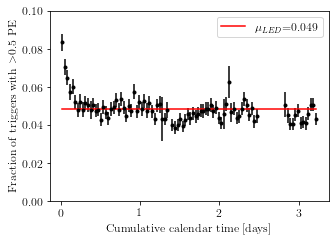

In [18]:
time_vec_all = (all_data[:,0]-np.min(all_data[:,0]))/(3600*24)

## calculate poisson rate
zero_cts = all_data[:,1] < 10
pe_cts = np.logical_not(zero_cts)
hh, be = np.histogram( time_vec_all, bins = 100 )
hh2, be2 = np.histogram( time_vec_all[pe_cts], bins = 100 )

bc = be2[:-1] + np.diff(be2)/2

r = hh2/hh
rerr = np.sqrt(hh2)/hh

totr=np.sum(pe_cts)/len(pe_cts)
totr_err=np.sqrt(np.sum(pe_cts))/len(pe_cts)

fig=plt.figure()
plt.errorbar( bc, r, yerr=rerr, fmt='k.')
plt.plot(bc, np.ones_like(bc)*totr, 'r', label="$\mu_{LED}$=%.3f"%(0.049))
plt.ylim(0,0.1)
plt.xlabel("Cumulative calendar time [days]")
plt.ylabel("Fraction of triggers with $>$0.5 PE")
plt.legend()
fig.set_size_inches(5,3.5)
plt.savefig('poisson_rate.pdf')


0.04823298310284408
15911
Refit fraction:  0.046464646464646465
Refit separated fraction:  0.022222222222222223


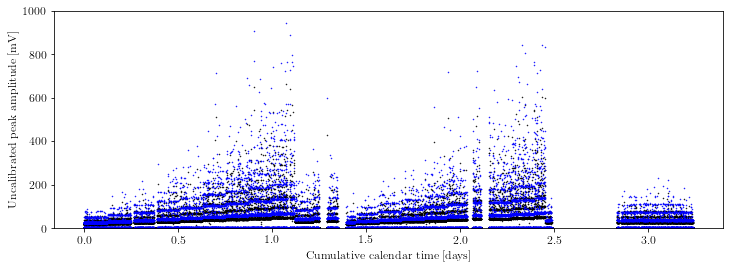

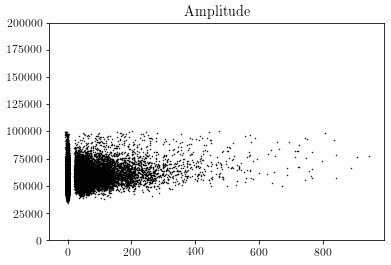

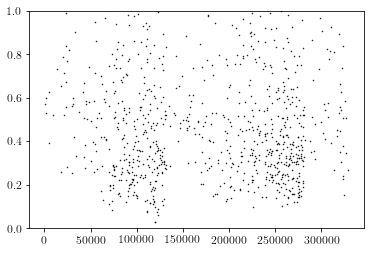

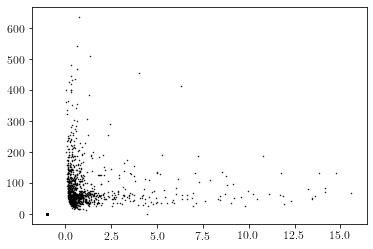

In [19]:
print(np.sum( all_data[:,1] > 10)/len(all_data[:,1])) 
print(np.sum( all_data[:,1] > 10))

fig=plt.figure()
time_vec_all = (all_data[:,0]-np.min(all_data[:,0]))/(3600*24)
plt.plot( time_vec_all, all_data[:,1], 'k.', ms=1, rasterized=True )
plt.plot( time_vec_all, fit_data[:,0], 'b.', ms=1, rasterized=True )
#plt.plot( time_vec_all, all_data[:,4], 'r.', ms=1, rasterized=True )
#time_vec_new = (new_data[:,0]-np.min(new_data[:,0]))/(3600*24)
#plt.plot( time_vec_new, new_data[:,1], 'b.', ms=1, rasterized=True )
#print(3.52*(3600*24)+all_data[0,0])
#plt.xlim((1.0, 1.5))
#plt.plot((0.4,2),(33.5,33.5),'r')
#plt.ylim((25,45))
plt.ylim((0,1000))
plt.xlabel("Cumulative calendar time [days]")
plt.ylabel("Uncalibrated peak amplitude [mV]")
fig.set_size_inches(12,4)
plt.savefig("amp_vs_time_uncal.pdf")


plt.figure()
plt.plot( fit_data[:,0], fit_data[:,1], 'k.', ms=1, rasterized=True )
plt.title("Amplitude")
plt.ylim(0,0.2e6)


## print the fraction of events that were refit and with late times
gpts = all_data[:,2] == 31.5
gpts = np.logical_and( gpts, all_data[:,1] > 10 )
plt.figure()
plt.plot( fit_data[:,3], 'k.', ms=1 )
plt.ylim([0,1])

gpts2 = np.logical_and( gpts, fit_data[:,3] > 0.6 )
print("Refit fraction: ", np.sum(fit_data[gpts,2])/np.sum(gpts))
print("Refit separated fraction: ", np.sum(fit_data[gpts2,2])/np.sum(gpts))

plt.figure()
plt.plot(fit_data[:,3],fit_data[:,6], 'k.', ms=1)

plt.show()


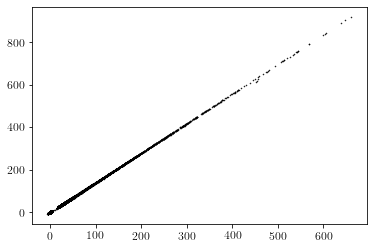

In [20]:
plt.figure()
#gpts = all_data[:,1] > 10
#gpts = fit_data[:,0]< 0
plt.plot(all_data[:,1], fit_data[:,4], 'k.', ms=1)
plt.show()

In [21]:
def gauss_fun(x, A, mu, sig):
    return A * np.exp( -(x-mu)**2/(2*sig**2) )

def lin_fun(x, m, x1):
    return m*(x-x1)

def lin_fun_const(x, m):
    return lin_fun(x,m,0)

In [22]:
def fit_hist(bc,hh, numsig=4, max_peaks=5):
    
    out_vals = []
    
    hh[bc < 10] =0
    
    spe_loc = bc[np.argmax(hh)]
    sig = spe_loc*0.05
    fpts = np.logical_and( bc >= spe_loc - numsig*sig, bc <= spe_loc + numsig*sig)
    
    bestp, covp = curve_fit(gauss_fun, bc[fpts], hh[fpts], p0=[1, spe_loc, sig])
    
    out_vals.append([1, bestp[1], np.sqrt(covp[1,1])])
    
    xx = np.linspace( spe_loc - numsig*sig, spe_loc + numsig*sig, 100 )
    plt.plot( xx, gauss_fun(xx, *bestp), 'r' )
    
    spe_loc = bestp[1]
    sig = np.abs(bestp[2])
    
    for n in range(2,max_peaks):
        
        fpts = np.logical_and( bc >= n*spe_loc - numsig*sig, bc <= n*spe_loc + numsig*sig)
        if(np.sum(fpts) == 0): 
            continue
        
        bestp, covp = curve_fit(gauss_fun, bc[fpts], hh[fpts], p0=[1, n*spe_loc, sig])
        
        out_vals.append([n, bestp[1], np.sqrt(covp[1,1])])
        
        xx = np.linspace( n*spe_loc - numsig*sig, n*spe_loc + numsig*sig, 100 )
        plt.plot( xx, gauss_fun(xx, *bestp), 'r' )
        
        sig = np.abs(bestp[2])
        
        
    return np.array(out_vals)

In [23]:
def calibrate_data(all_data, ov_data, max_peaks=4, idx=0):

    OV_list = np.unique(ov_data)
    print(OV_list)
    
    gain_vs_ov = np.zeros((len(OV_list),4))

    for i, ov in enumerate(OV_list):
        gpts = ov_data == ov

        hh, be = np.histogram(all_data[gpts], bins=np.arange(0, 400, 2))
        bc = be[:-1] + np.diff(be)/2

        plt.figure()
        plt.step(be[:-1], hh, where='post', color='k')
        plt.gca().set_yscale('log')
        yy = plt.ylim()

        gain_list = fit_hist(bc,hh, max_peaks=max_peaks)
        plt.ylim(yy)
        plt.xlim(0,400)
        
        plt.title("Gain calibration, bias voltage = %.1f"%ov)
        plt.ylabel("Counts")
        plt.xlabel("Amplitude (mV)")
        plt.savefig("gain_calib_%s_%.1f.pdf"%(idx,ov))
        
        plt.figure()
        plt.errorbar(gain_list[:,0], gain_list[:,1], yerr=gain_list[:,2], fmt='k.')
        

        linfitp, linfitcov = curve_fit(lin_fun_const, gain_list[:,0], gain_list[:,1], sigma=gain_list[:,2])

        
        xx = np.linspace(0, np.max(gain_list[:,0]), 400)
        plt.plot(xx, lin_fun_const(xx,*linfitp), 'r', label="Gain = %.2f $\pm$ %.2f mV/PE"%(linfitp, np.sqrt(linfitcov)))
        plt.legend()
        
        gain_vs_ov[i,0] = linfitp
        gain_vs_ov[i,1] = np.sqrt(linfitcov)
        gain_vs_ov[i,2] = gain_list[0,1]
        gain_vs_ov[i,3] = gain_list[0,2]
        
        plt.title("Gain fit, bias voltage = %.1f"%ov)
        plt.ylabel("Counts")
        plt.xlabel("Amplitude (mV)")
        plt.savefig("gain_fit_%s_%.1f.pdf"%(idx,ov))
    
    return gain_vs_ov, OV_list

[30.  30.5 31.  31.5 32.  32.5 33.  33.5 34. ]


/gpfs/loomis/project/david_moore/dcm42/conda_envs/new_env2/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[30.  30.5 31.  31.5 32.  32.5 33.  33.5 34. ]


/gpfs/loomis/project/david_moore/dcm42/conda_envs/new_env2/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


[30.  30.5 31.  31.5 32.  32.5 33.  33.5 34. ]
[30.  30.5 31.  31.5 32.  32.5 33.  33.5 34. ]
[30.  30.5 31.  31.5 32.  32.5 33.  33.5 34. ]
[30.  30.5 30.8 31.  31.5 32.  32.5 33.  33.5 34. ]


/gpfs/loomis/project/david_moore/dcm42/conda_envs/new_env2/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


[30.  30.5 30.8 31.  31.5 32.  32.5 33.  33.5 34. ]
[30.  30.5 30.8 31.  31.5 32.  32.5 33.  33.5 34. ]
[30.  30.5 30.8 31.  31.5 32.  32.5 33.  33.5 34. ]
[30.  30.5 30.8 31.  31.5 32.  32.5 33.  33.5 34. ]
[30.  30.5 30.8 31.  31.5 32.  32.5 33.  33.5 34. ]
[30.  30.5 30.8 31.  31.5 32.  32.5 33.  33.5 34. ]


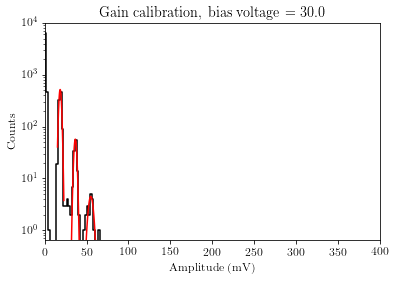

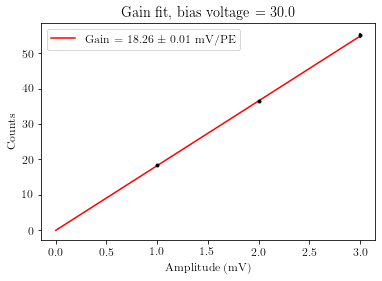

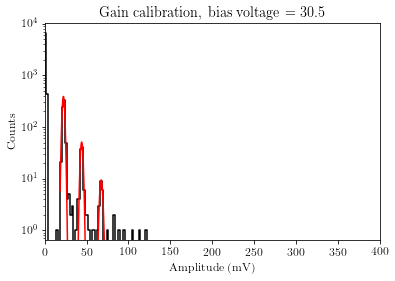

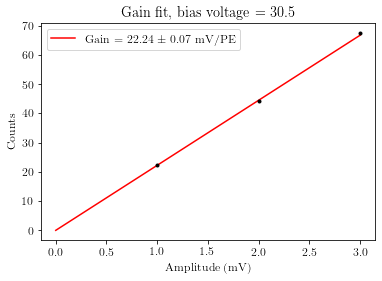

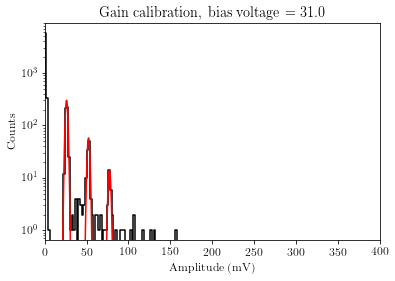

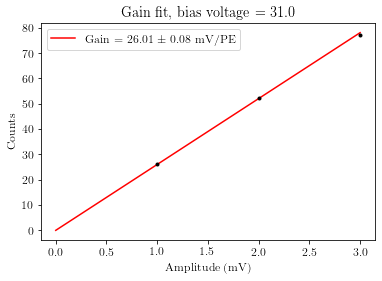

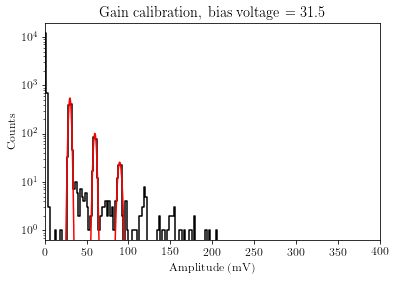

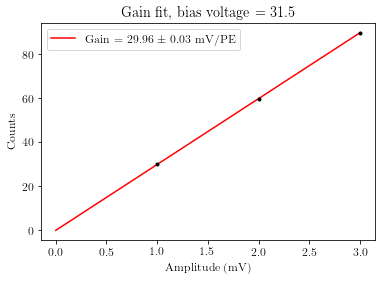

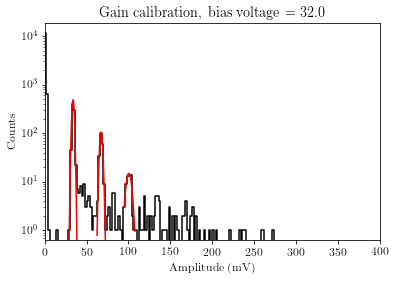

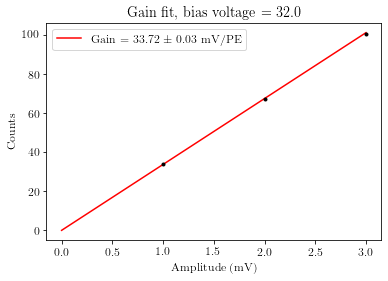

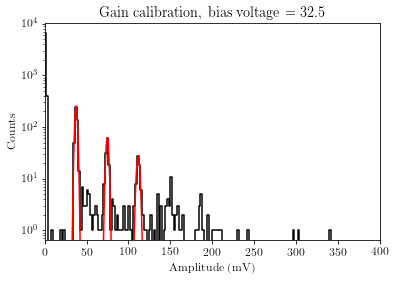

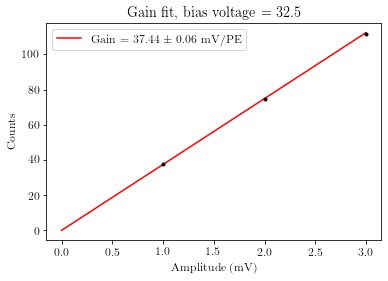

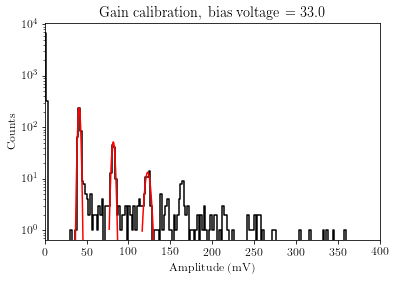

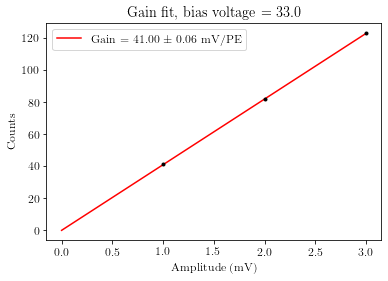

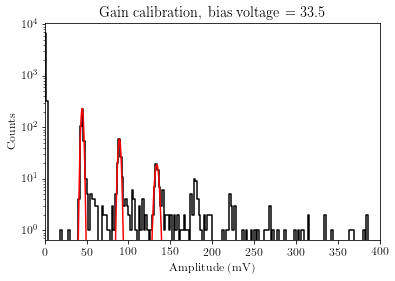

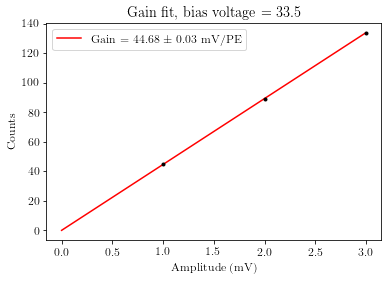

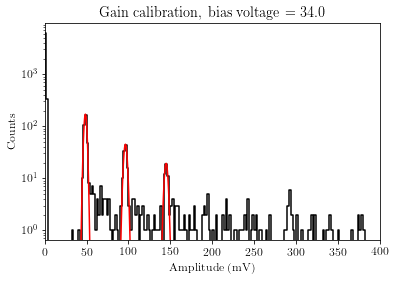

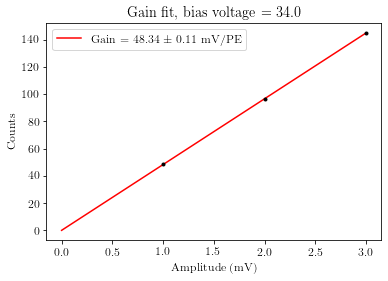

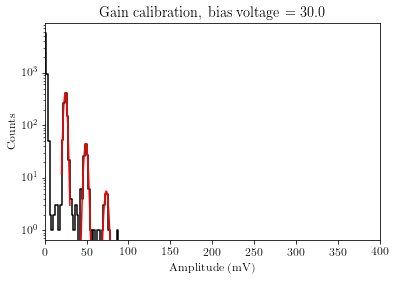

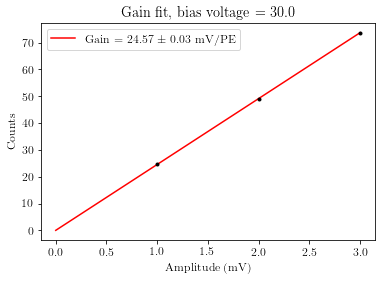

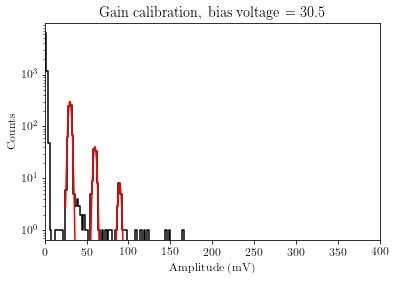

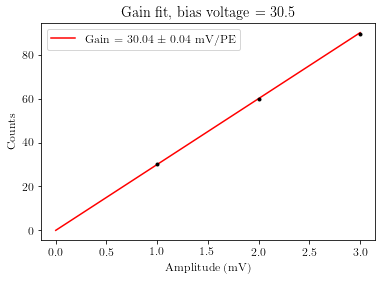

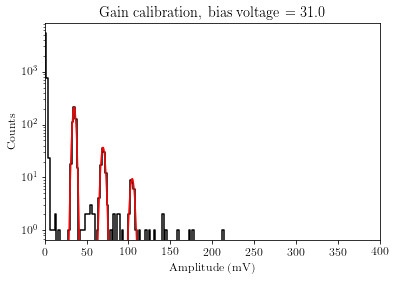

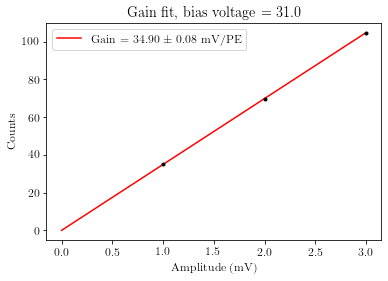

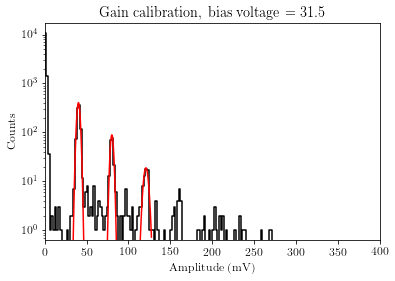

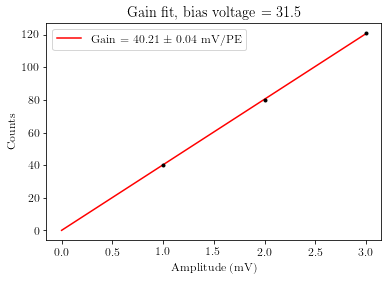

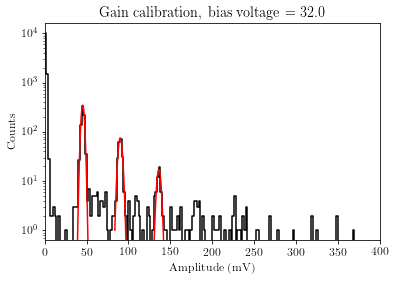

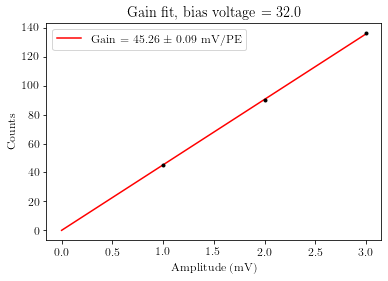

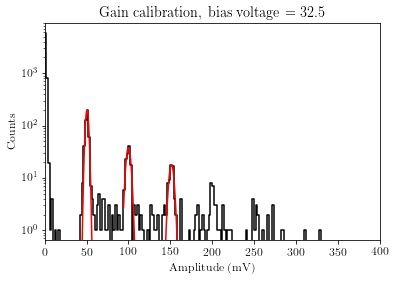

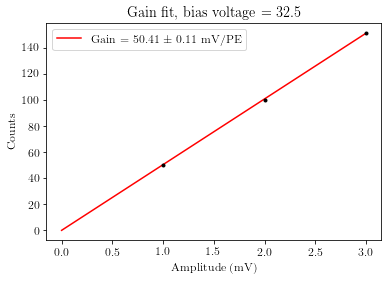

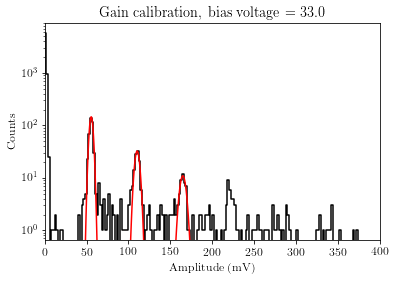

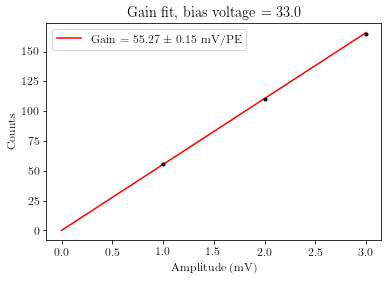

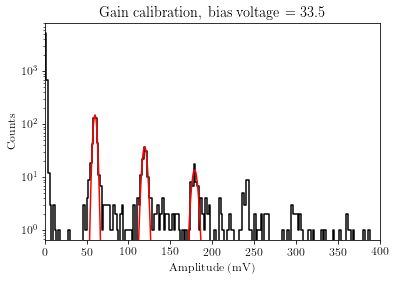

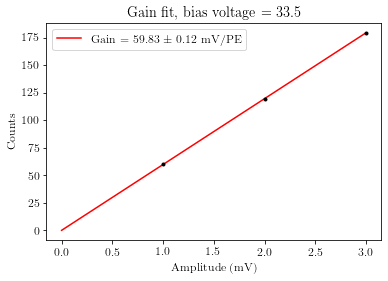

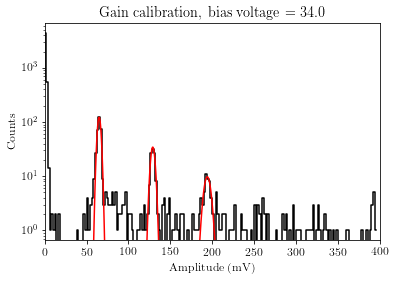

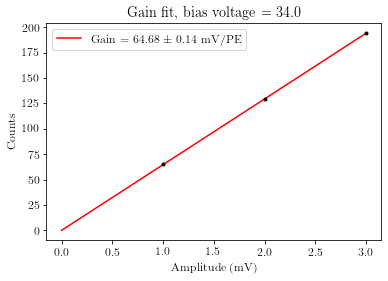

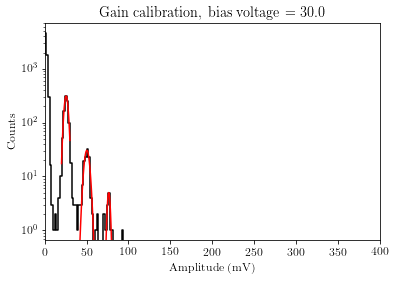

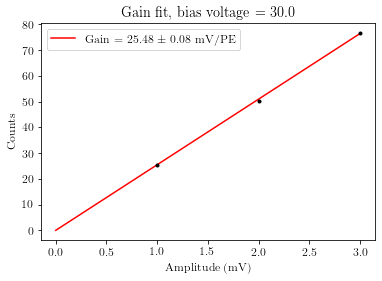

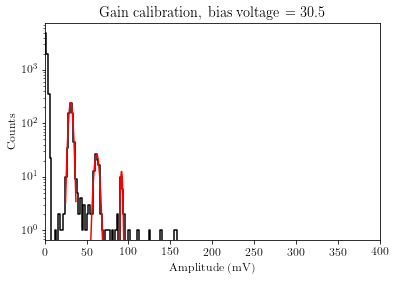

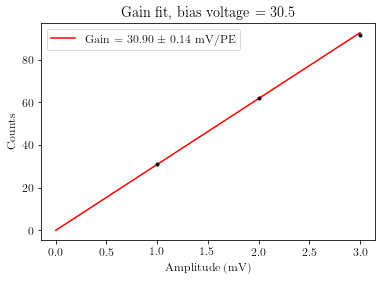

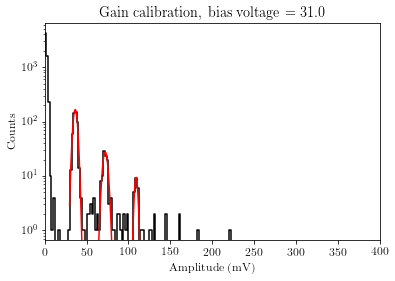

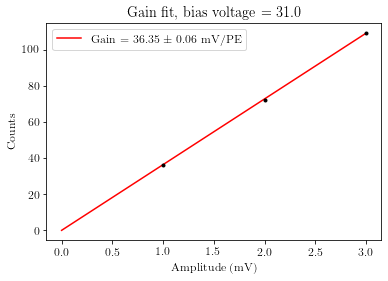

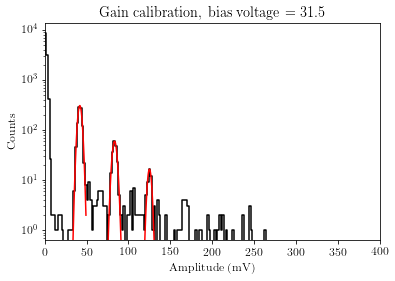

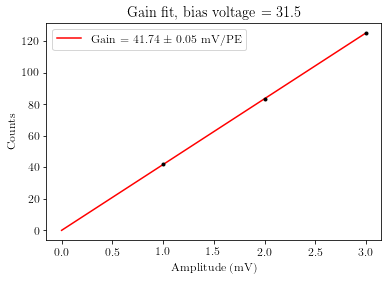

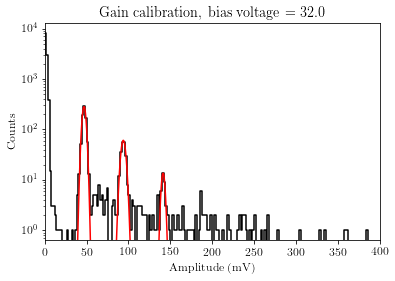

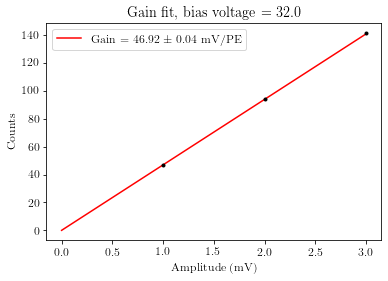

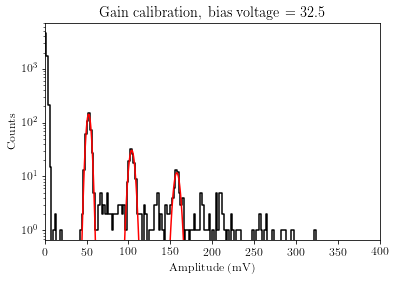

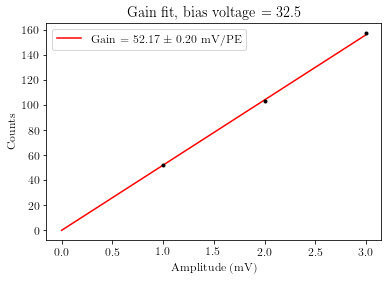

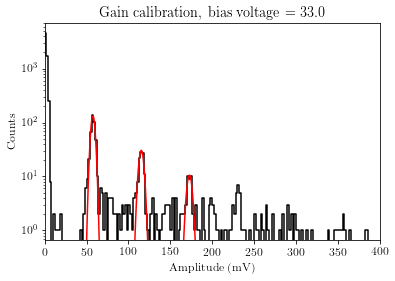

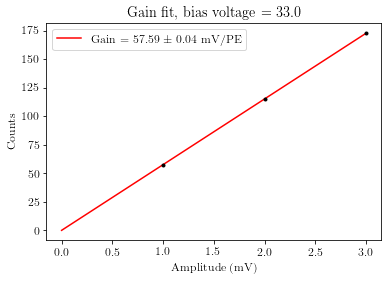

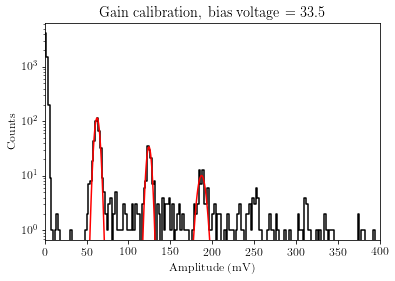

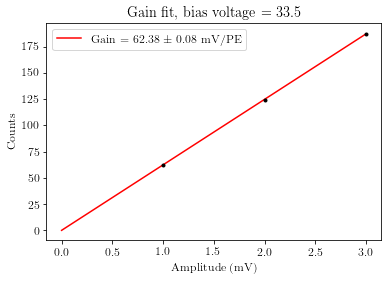

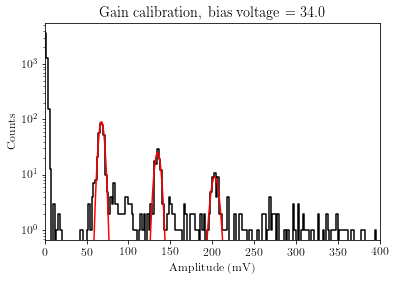

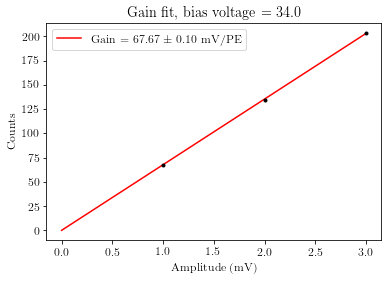

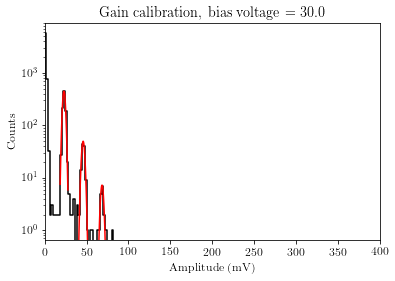

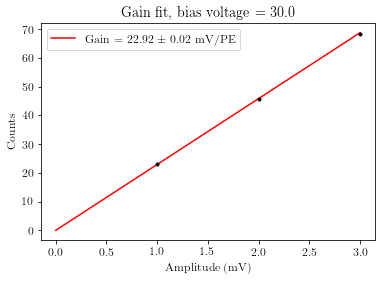

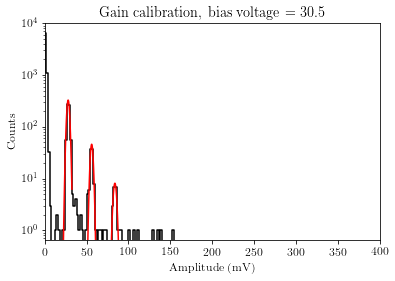

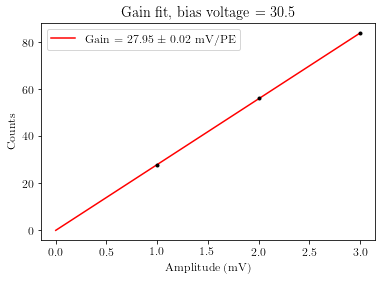

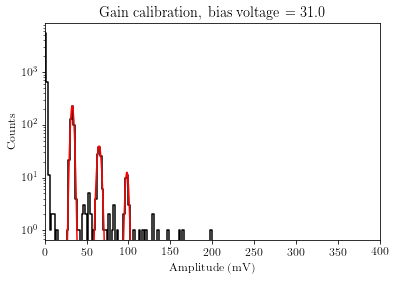

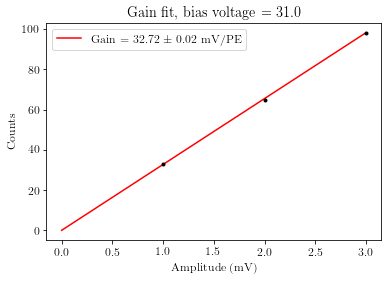

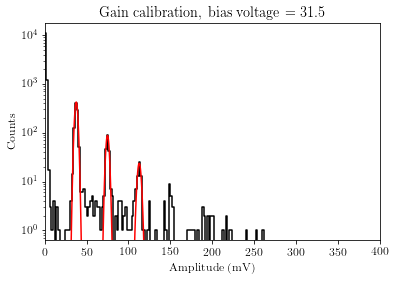

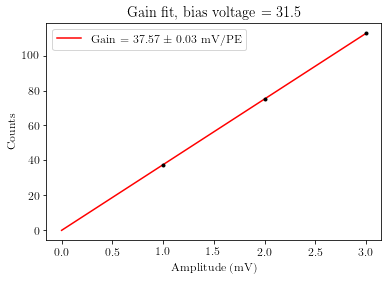

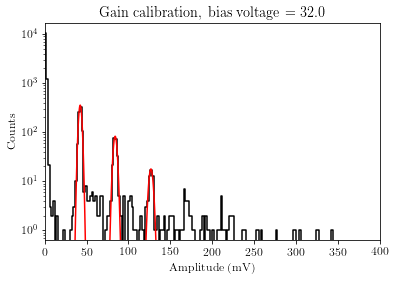

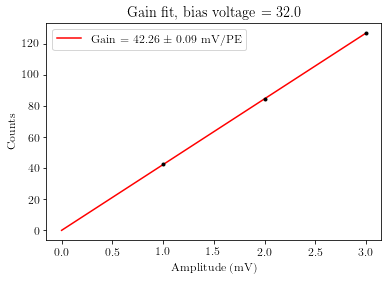

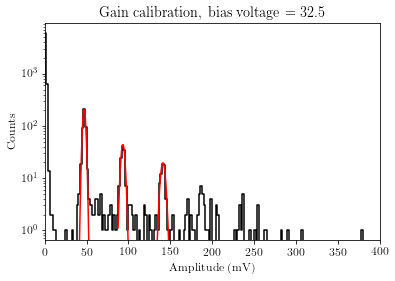

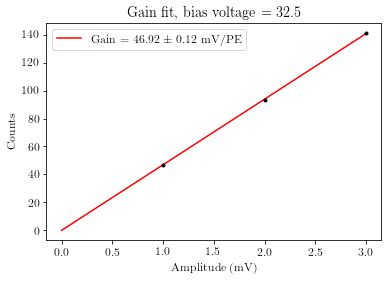

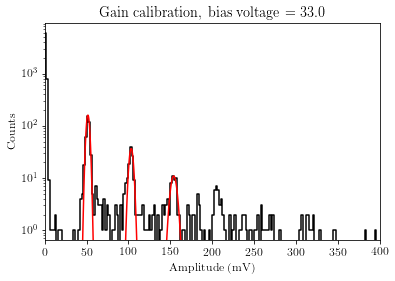

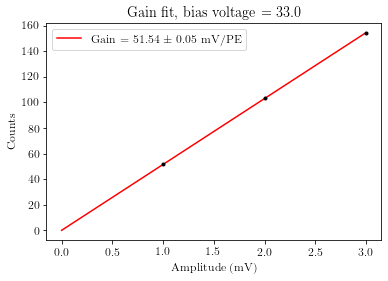

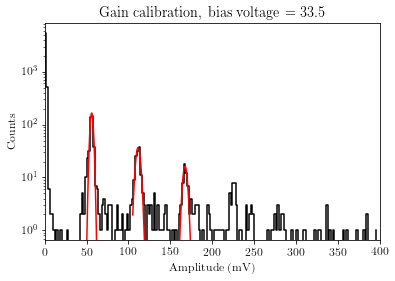

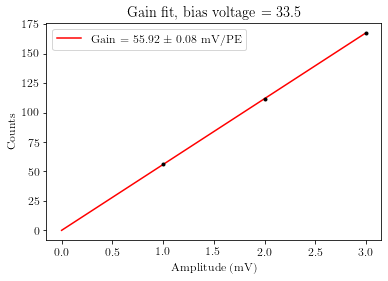

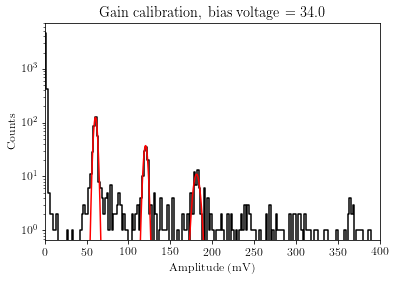

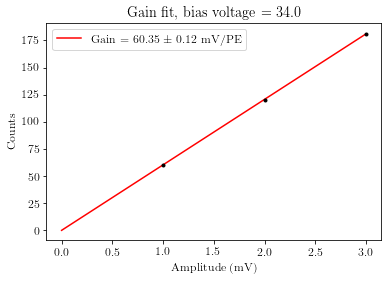

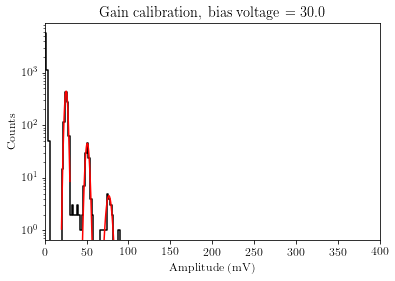

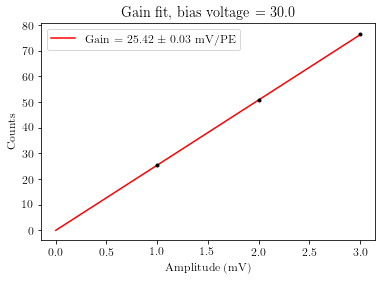

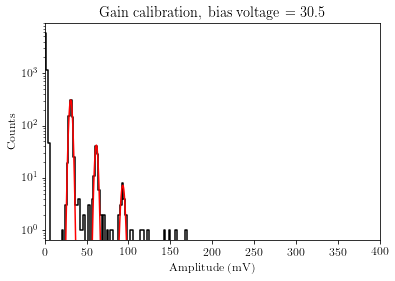

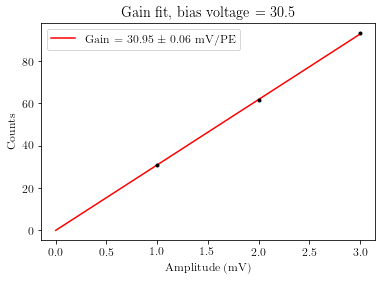

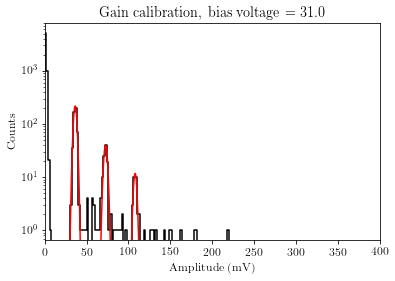

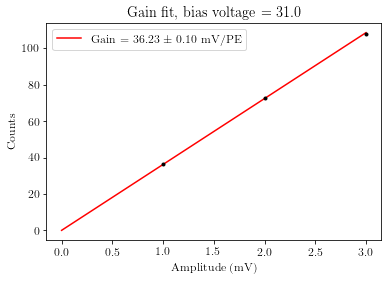

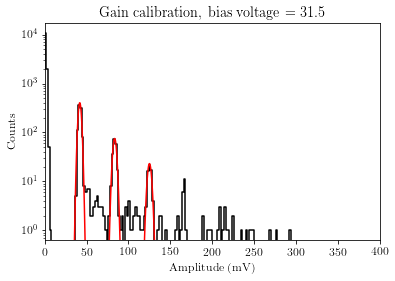

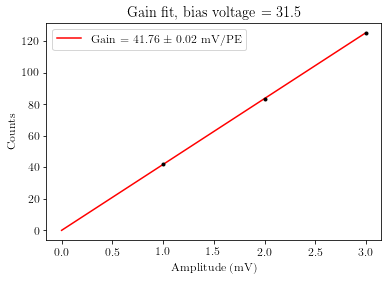

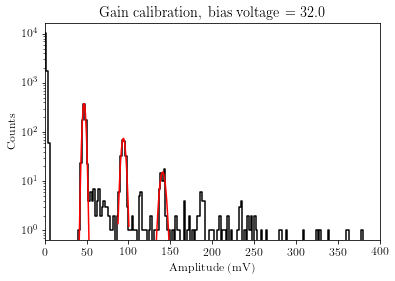

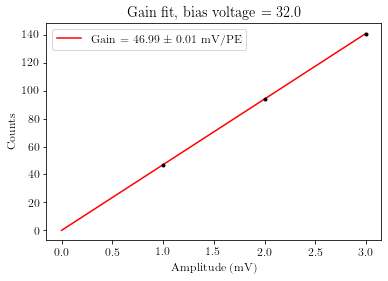

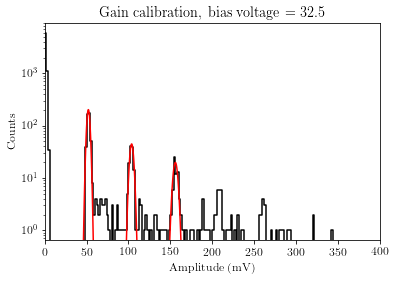

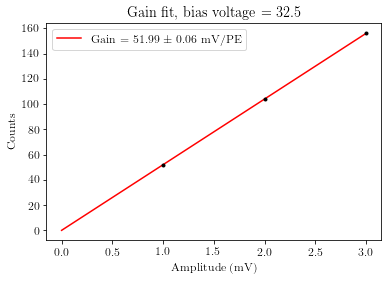

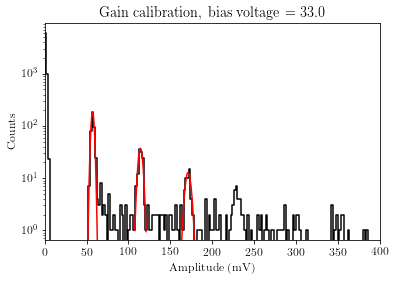

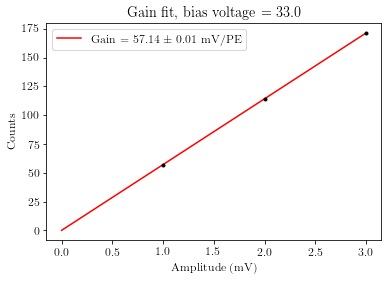

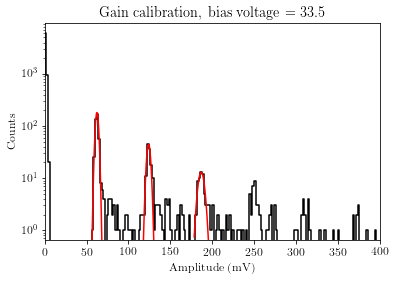

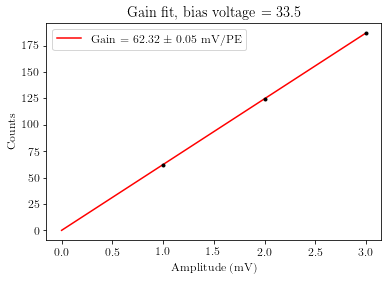

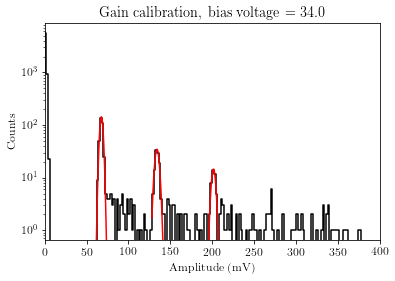

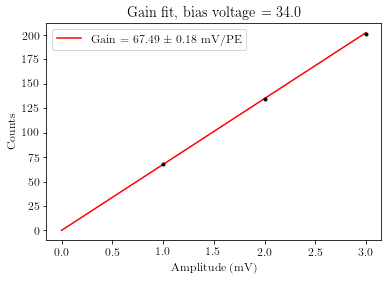

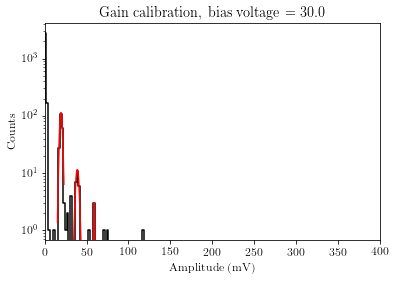

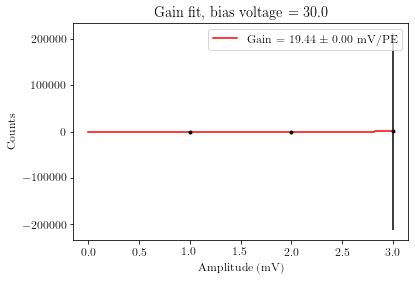

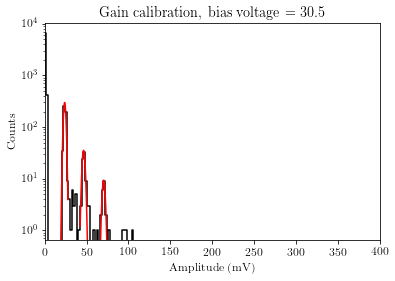

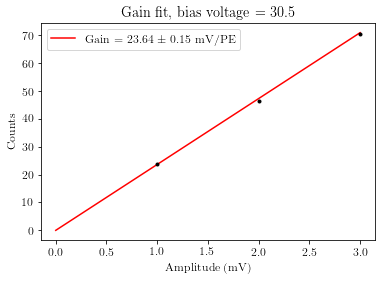

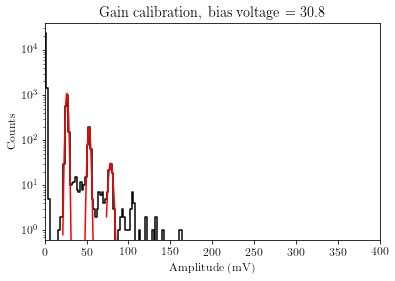

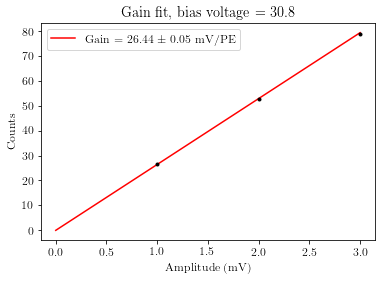

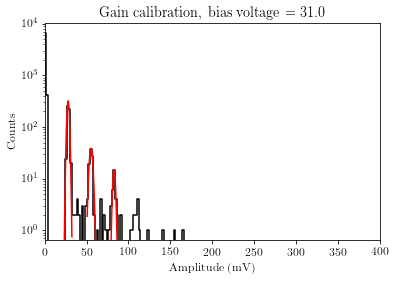

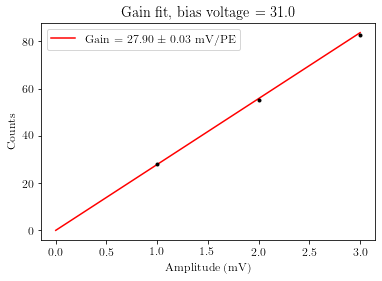

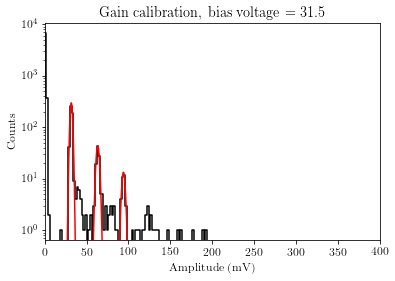

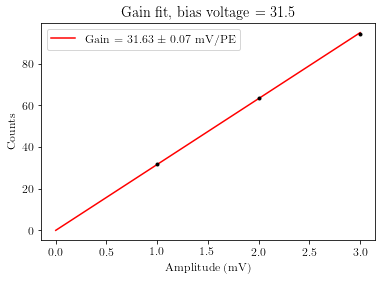

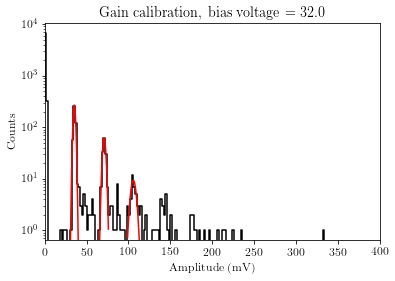

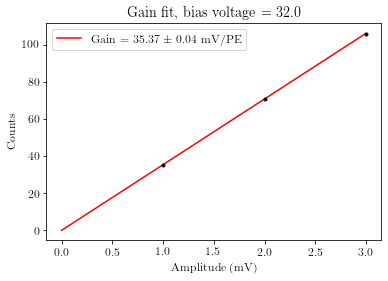

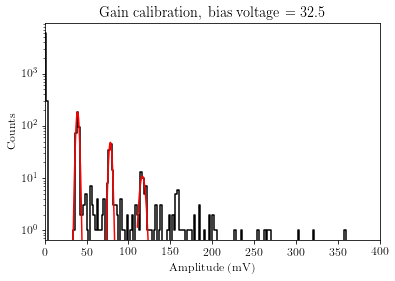

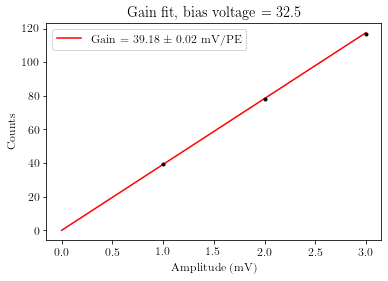

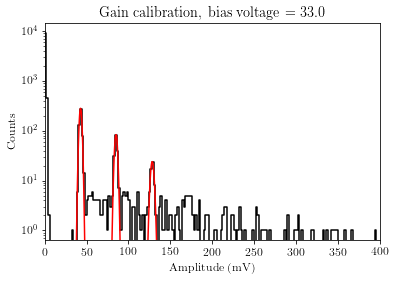

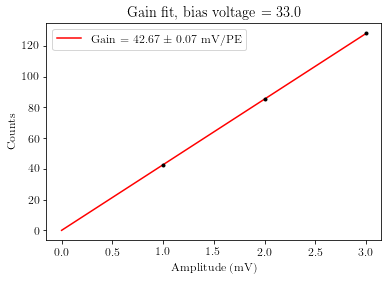

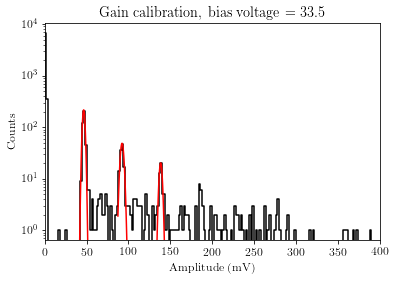

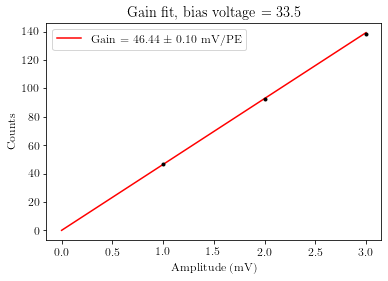

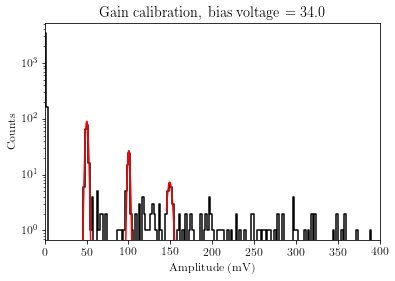

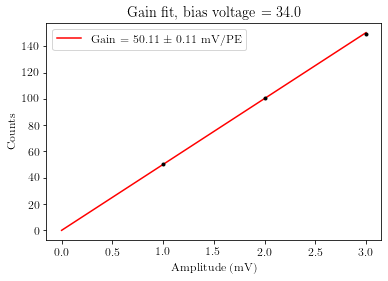

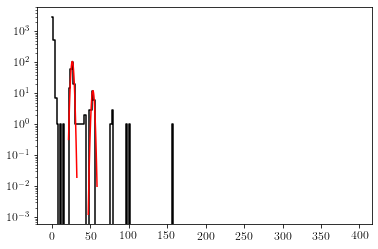

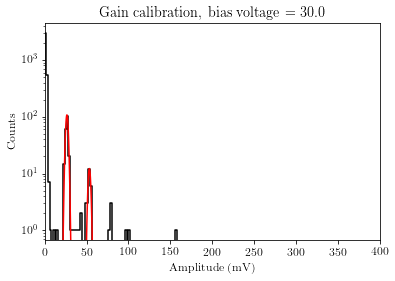

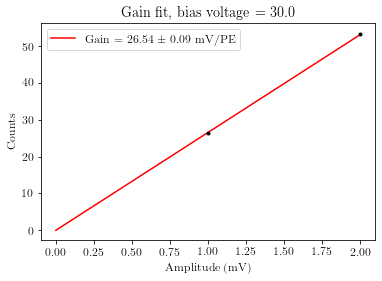

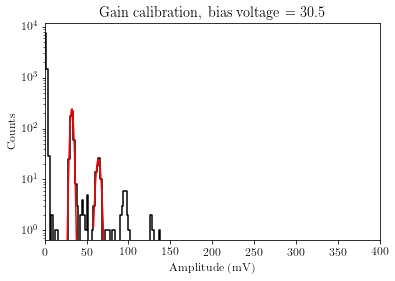

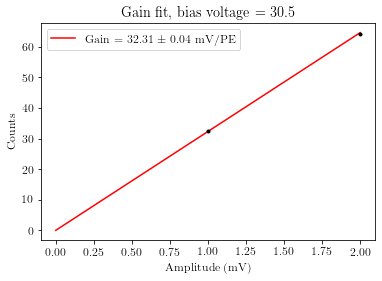

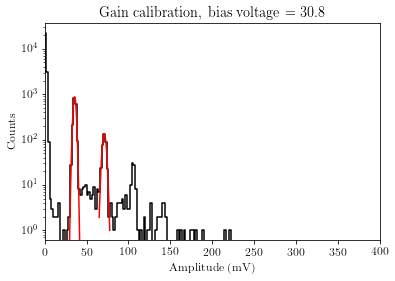

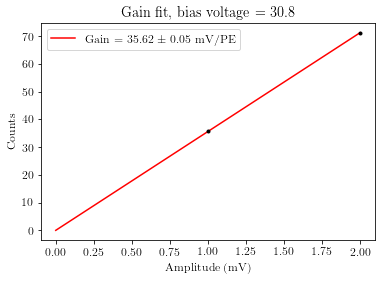

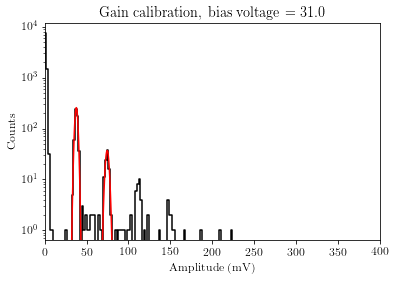

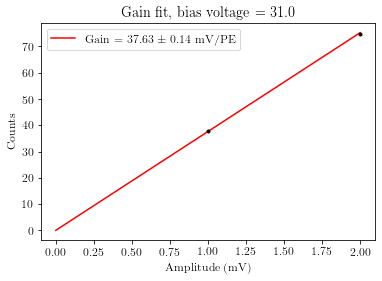

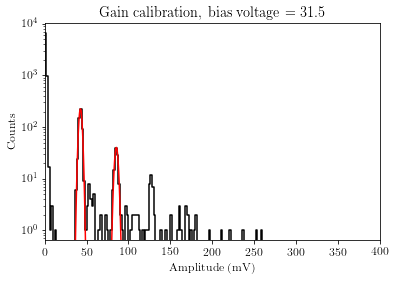

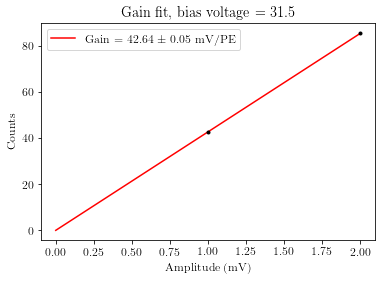

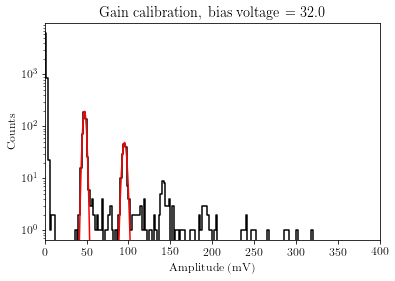

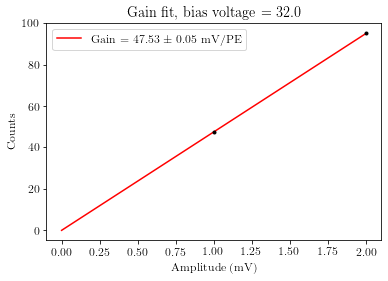

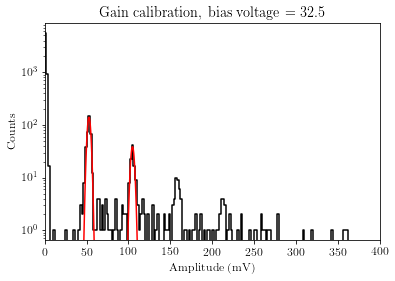

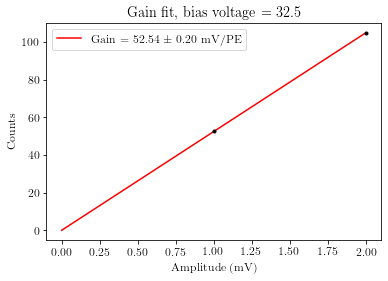

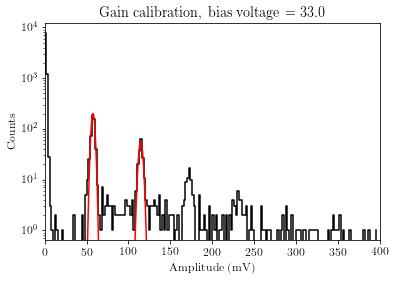

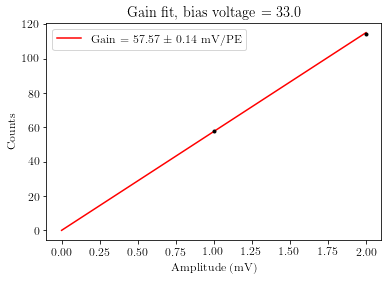

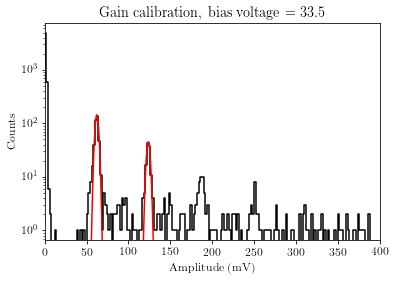

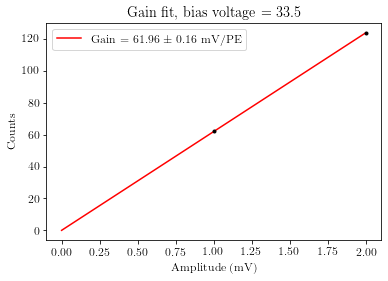

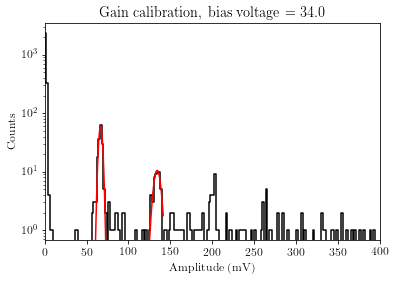

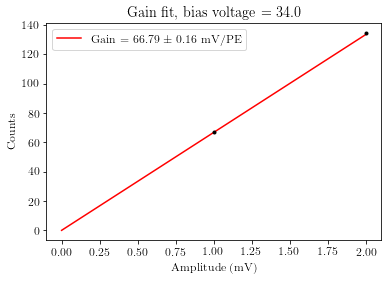

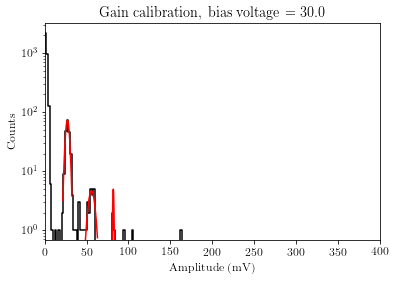

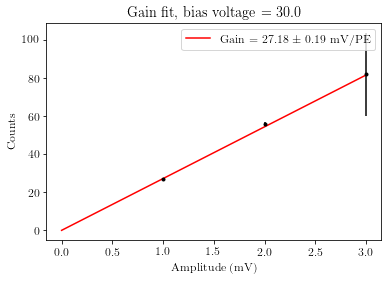

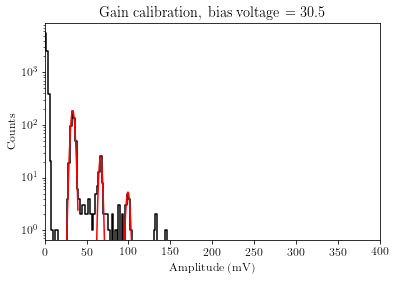

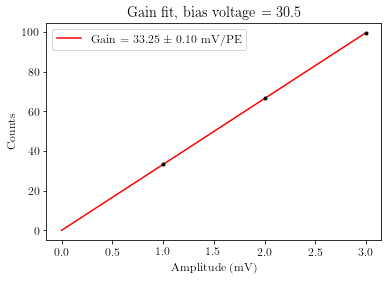

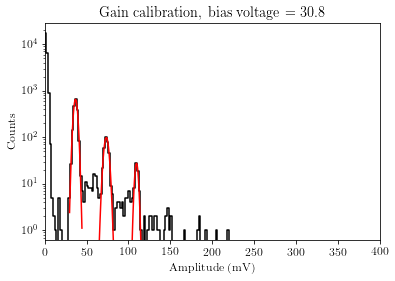

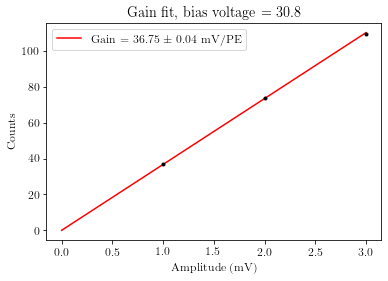

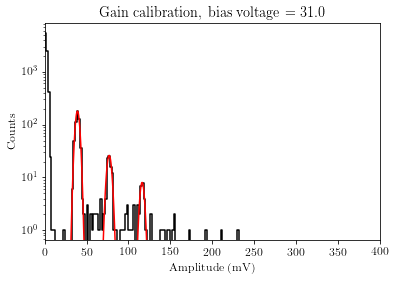

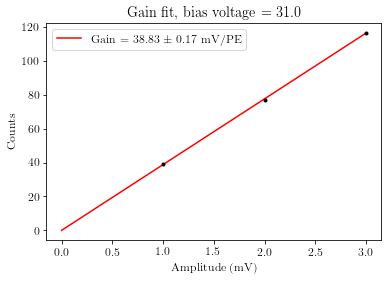

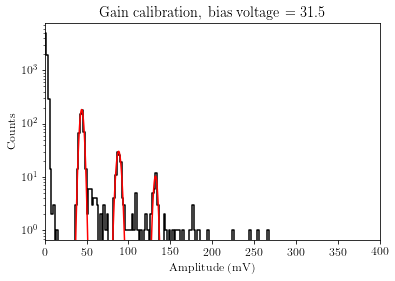

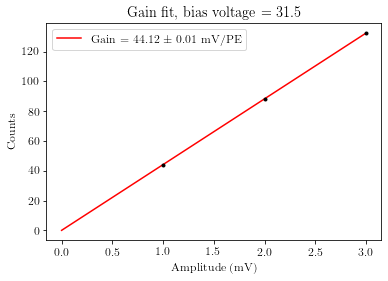

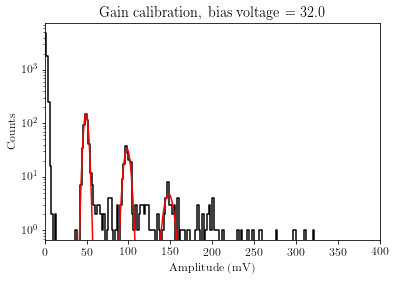

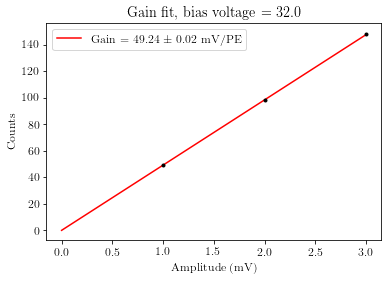

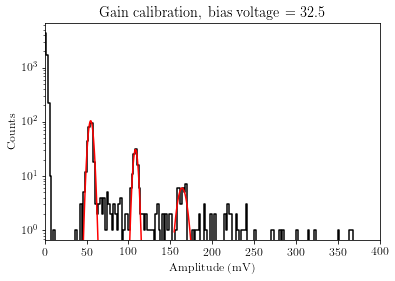

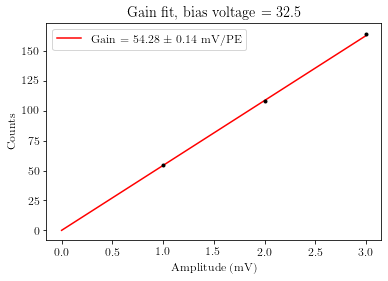

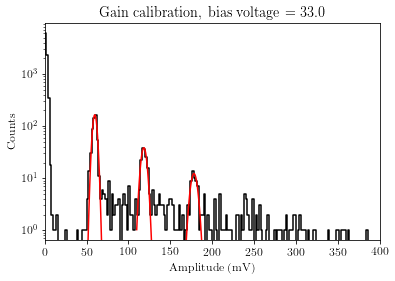

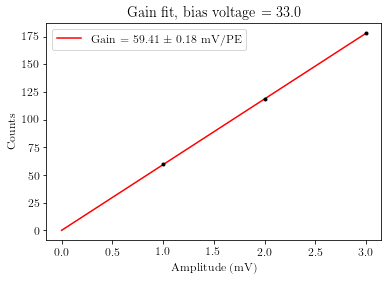

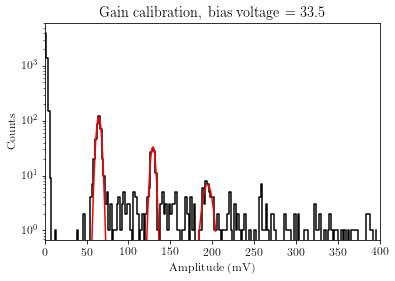

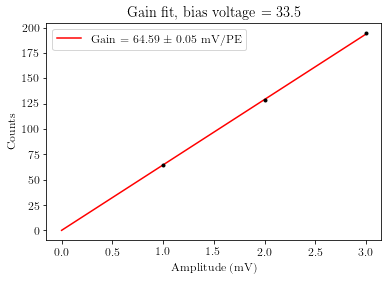

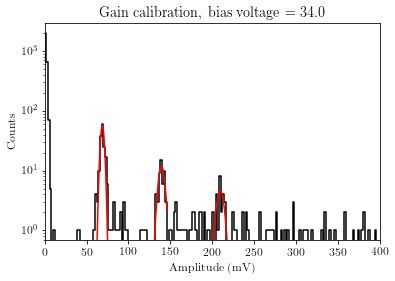

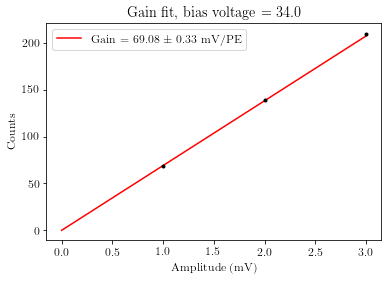

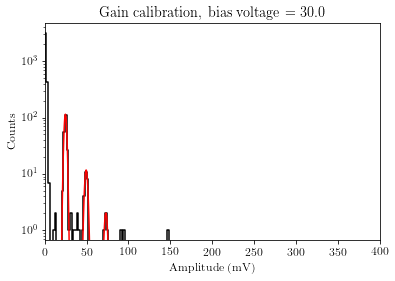

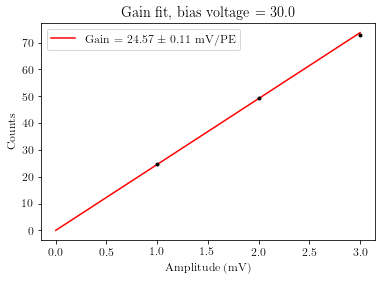

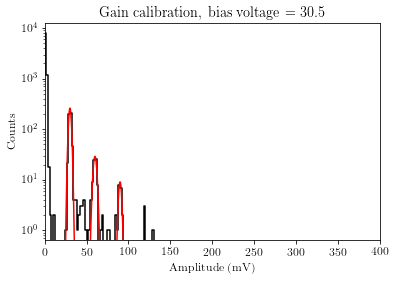

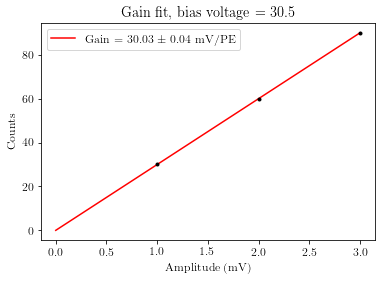

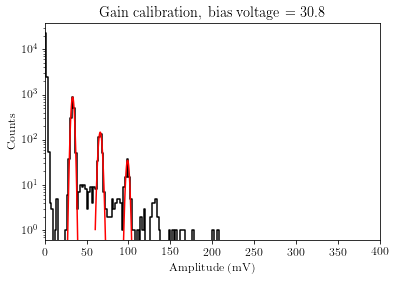

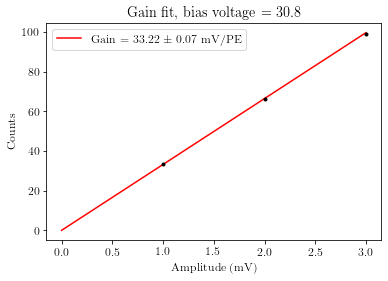

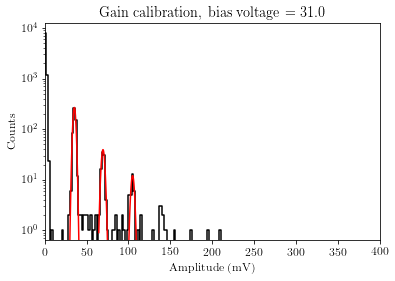

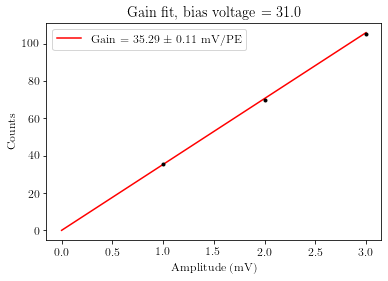

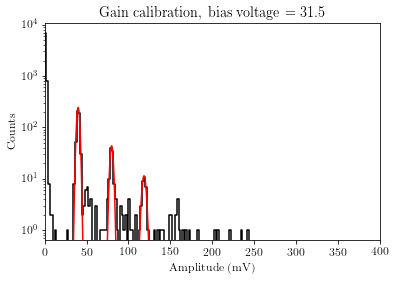

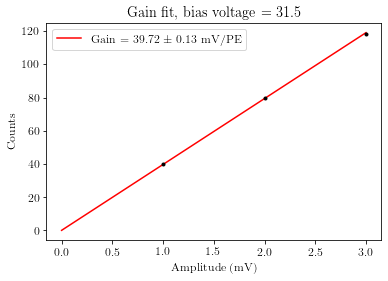

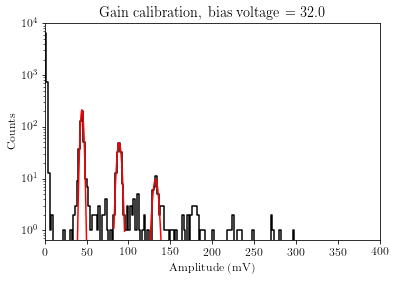

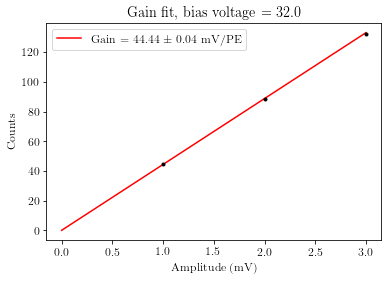

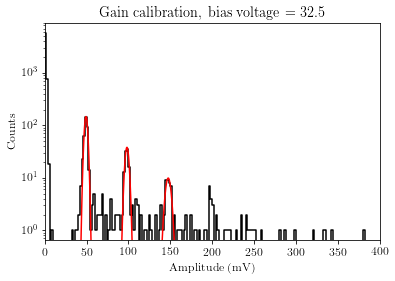

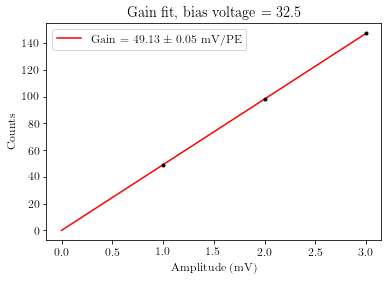

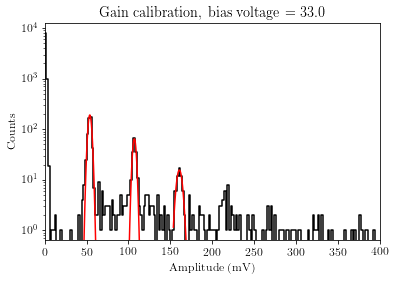

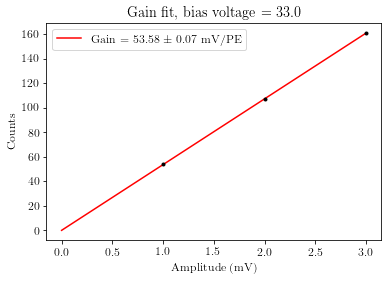

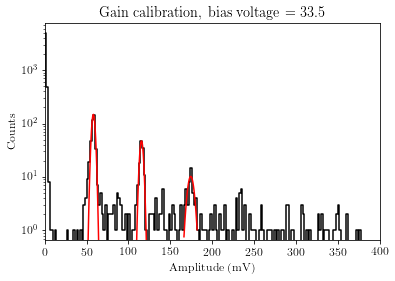

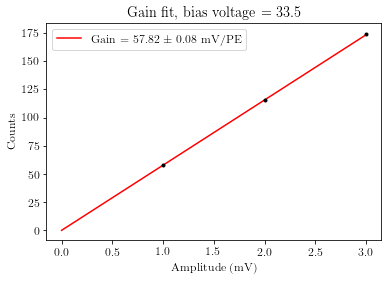

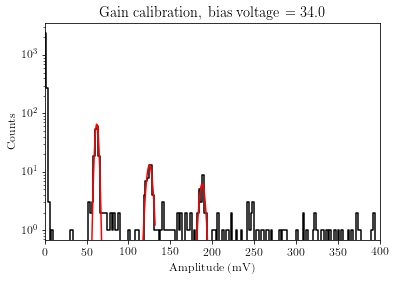

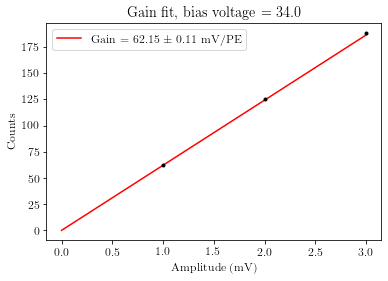

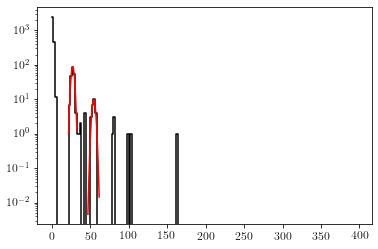

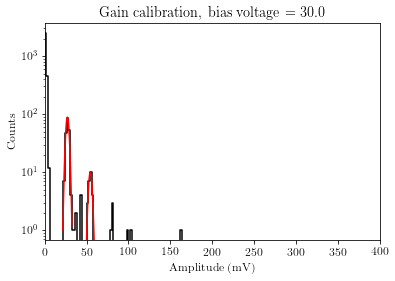

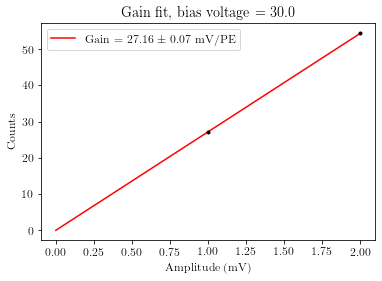

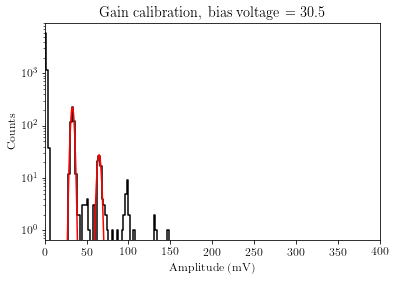

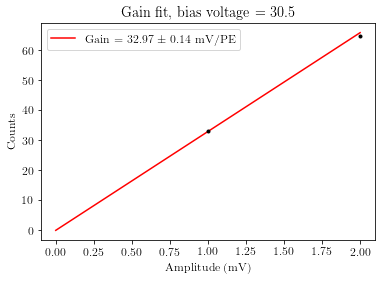

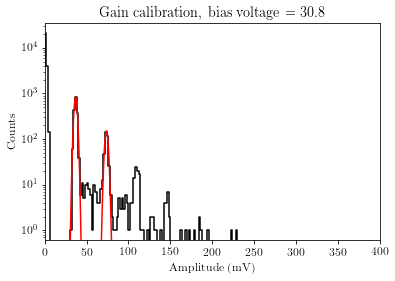

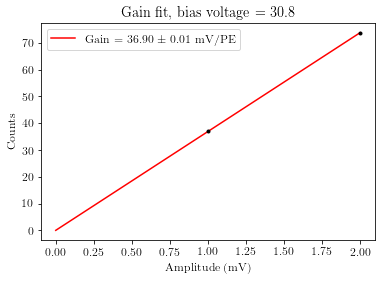

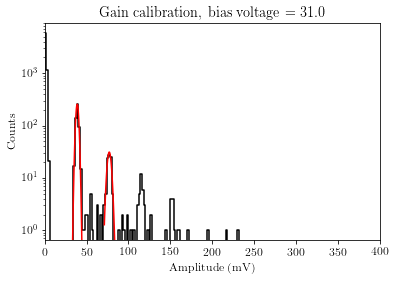

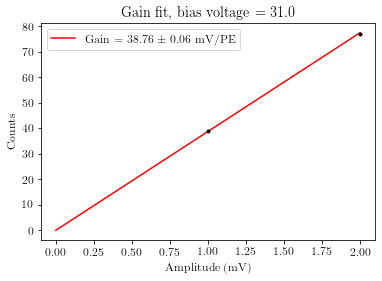

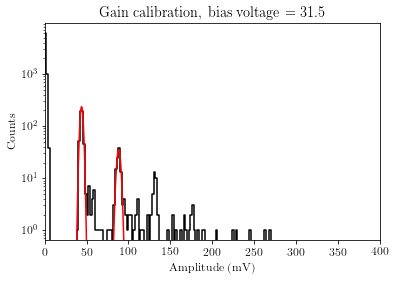

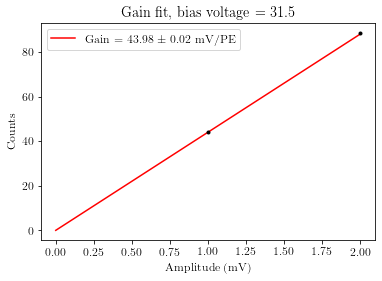

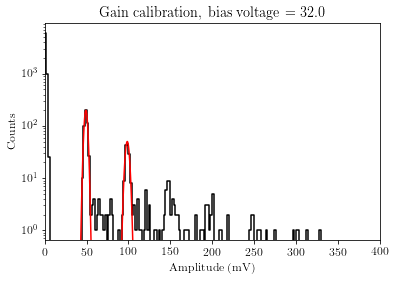

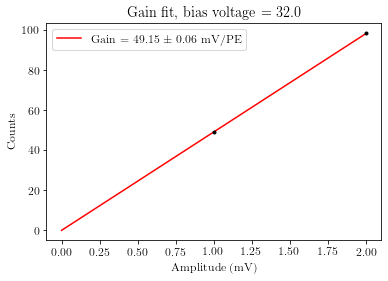

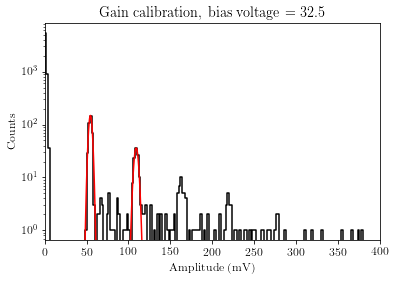

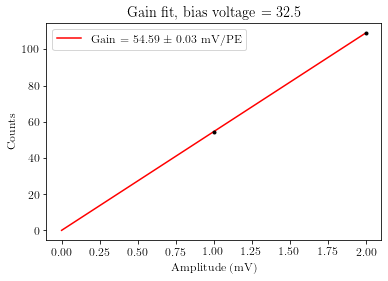

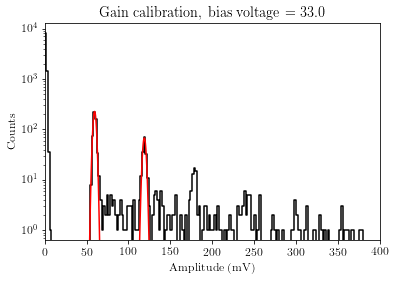

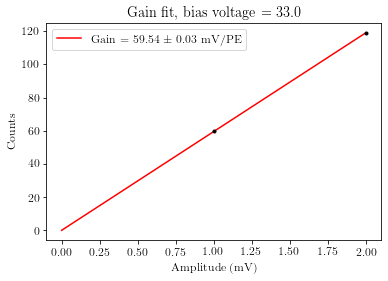

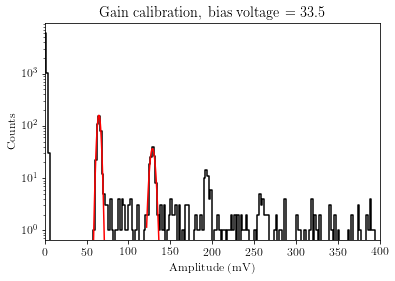

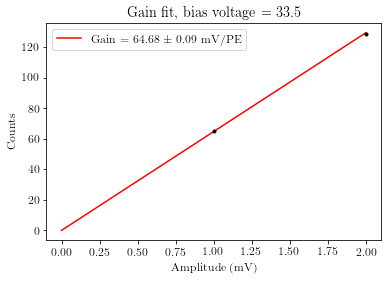

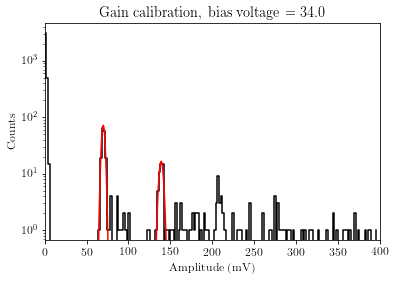

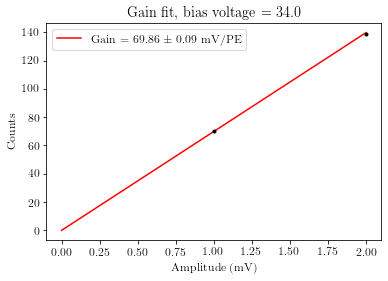

In [24]:
## now cut data up into chunks, each of which requires a new calibration
chunk_ends = [-1, 1.37, 10]
data_dict = {}
ov_dict = {}
for i in range(1,len(chunk_ends)):
    gpts = np.logical_and( time_vec_all < chunk_ends[i], time_vec_all > chunk_ends[i-1] )
    data_dict[str(i) + "_integ"] = all_data[ gpts, 1]
    data_dict[str(i) + "_f10"] = all_data[ gpts, 5]
    data_dict[str(i) + "_f5"] = all_data[ gpts, 4]
    data_dict[str(i) + "_f15"] = all_data[ gpts, 6]
    data_dict[str(i) + "_fit"] = fit_data[ gpts, 0]
    #data_dict[str(i) + "ap_amp_fit"] = fit_data[ gpts, :]
    ov_dict[str(i)] = all_data[ gpts, 2]
    
gain_dict = {}
didx = data_dict.keys()

for d in didx:
    curr_data = data_dict[d]
    if("ap_amp" in d): continue
    
    try:
        gain_data, OV_list = calibrate_data(curr_data, ov_dict[d[0]], max_peaks=4, idx=d)
    except RuntimeError:
        gain_data, OV_list = calibrate_data(curr_data, ov_dict[d[0]], max_peaks=3, idx=d)
    gain_dict[d] = [gain_data, OV_list]
    
plt.show()

In [25]:
def plot_gain_data(fig1, fig2, fig3, OV_list, gain_vs_ov, dc='k', lc='r'):

    plt.figure(fig1.number)
    plt.errorbar(OV_list, gain_vs_ov[:,0], yerr=gain_vs_ov[:,1], fmt=dc+'.')

    gerr = gain_vs_ov[:,1]
    #print(gerr)
    gerr[gerr < 0.05] = 0.05
    linfitp, linfitcov = curve_fit(lin_fun, OV_list, gain_vs_ov[:,0], sigma=gerr)
    linfiterr = np.sqrt(linfitcov[1,1])
    xx = np.linspace(26, 37, 100 )
    plt.plot( xx, lin_fun(xx, *linfitp), lc, label=r"$V_{bd} = %.2f \pm %.2f$"%(linfitp[1], linfiterr))
    plt.plot(xx, np.zeros_like(xx), 'k:')
    
    yy = plt.ylim()
    plt.fill_between( [linfitp[1]-linfiterr, linfitp[1]+linfiterr], [yy[0], yy[0]], [yy[1], yy[1]], ec=None, fc=[0,0,1], alpha=0.5)
    plt.ylim(yy)
    
    plt.figure(fig2.number)
    plt.errorbar(OV_list, gain_vs_ov[:,0]-lin_fun(OV_list, *linfitp), yerr=gain_vs_ov[:,1], fmt=dc+'.')
    
    plt.figure(fig3.number)
    plt.errorbar(OV_list, gain_vs_ov[:,2], yerr=gain_vs_ov[:,3], fmt=dc+'.')

    gerr = gain_vs_ov[:,3]
    #print(gerr)
    gerr[gerr < 0.05] = 0.05
    linfitp2, linfitcov2 = curve_fit(lin_fun, OV_list, gain_vs_ov[:,2], sigma=gerr)
    linfiterr2 = np.sqrt(linfitcov2[1,1])
    xx = np.linspace(26, 37, 100 )
    plt.plot( xx, lin_fun(xx, *linfitp2), lc, label=r"$V_{bd} = %.2f \pm %.2f$"%(linfitp2[1], linfiterr2))
    plt.plot(xx, np.zeros_like(xx), 'k:')
    
    yy = plt.ylim()
    plt.fill_between( [linfitp2[1]-linfiterr2, linfitp2[1]+linfiterr2], [yy[0], yy[0]], [yy[1], yy[1]], ec=None, fc=[0,0,1], alpha=0.5)
    plt.ylim(yy)
    
    return linfitp[1], linfiterr, linfitp2[1], linfiterr2


[[2.75478785e+01 3.04843479e-02 2.75035257e+01 2.41309370e-02]
 [2.73856577e+01 5.63988339e-02 2.72797453e+01 2.74512591e-02]]


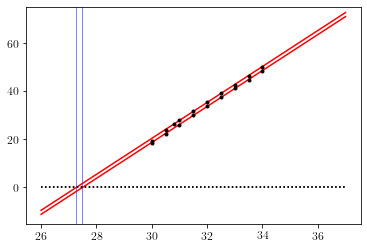

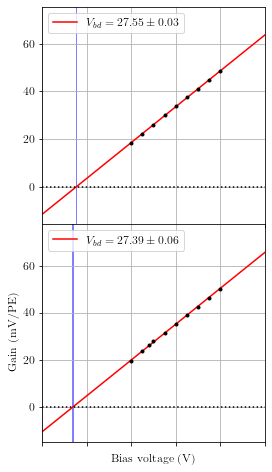

[[27.54554337  0.03134874 27.54487242  0.02951588]
 [27.28623277  0.04847522 27.24050142  0.0421565 ]]


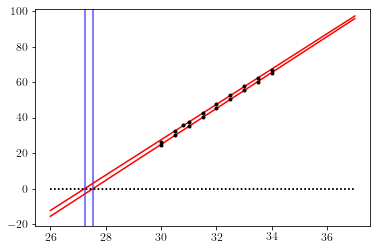

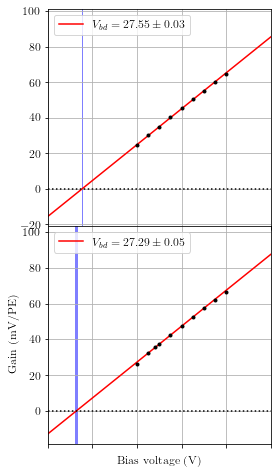

[[2.75569936e+01 2.65771771e-02 2.75711386e+01 2.29483962e-02]
 [2.72560956e+01 3.25356135e-02 2.72726245e+01 4.77400868e-02]]


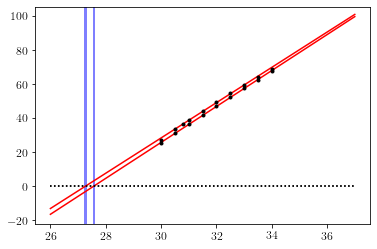

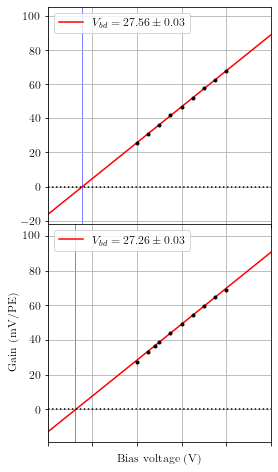

[[27.53931637  0.02826104 27.54486485  0.03027018]
 [27.26707844  0.05360854 27.25684648  0.06849985]]


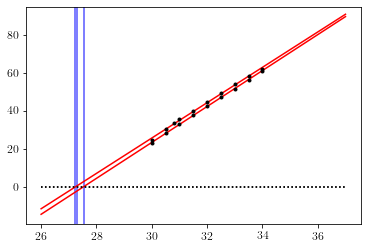

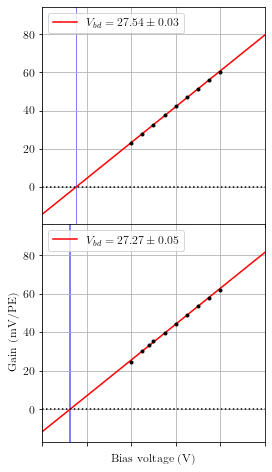

[[2.75565822e+01 2.70166932e-02 2.75259210e+01 2.17046807e-02]
 [2.73351191e+01 4.80351205e-02 2.73188909e+01 3.82672117e-02]]


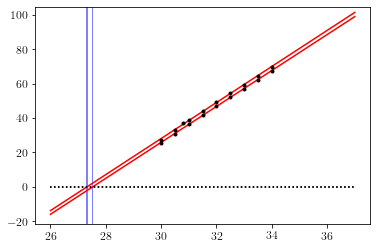

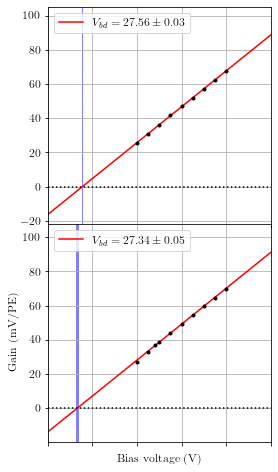

In [26]:
#didx = data_dict.keys()
#print(didx)

recon_list = ['_integ', "_f10",  "_f5", "_f15", "_fit"]

vbd_dict = {}

for r in recon_list:
    
    plt.close('all')
    fig1=plt.figure()
    fig2=plt.figure()
    fig3=plt.figure()
    
    vbd_list = []
    
    for d in [1,2]:

        k = str(d) + r
        gain_data = gain_dict[k][0]
        OV_list = gain_dict[k][1]

        gpts = gain_data > 10

        plt.figure(fig1.number)
        plt.subplot(2, 1, d)
        vbd, vbd_err, vbd2, vbd2_err = plot_gain_data(fig1, fig2, fig3, OV_list, gain_data)
        plt.figure(fig1.number)
        plt.grid(True)
        plt.xlim([26, 36])
        plt.legend(loc="upper left")

        if(d==2): plt.ylabel("Gain (mV/PE)")
        if(d < len(didx)):
            plt.gca().set_xticklabels([])

        vbd_list.append( [vbd, vbd_err, vbd2, vbd2_err] )

    vbd_list = np.array(vbd_list)
    print(vbd_list)
    
    vbd_dict[r] = vbd_list

    plt.figure(fig1.number)

    plt.xlabel("Bias voltage (V)")

    plt.subplots_adjust(hspace=0)

    fig1.set_size_inches(4,8)
    plt.savefig("gain_extrap%s.pdf"%r)
    
    plt.figure(fig2.number)
    plt.close()
    
    plt.show()


dict_keys(['1_integ', '1_f10', '1_f5', '1_f15', '1_fit', '2_integ', '2_f10', '2_f5', '2_f15', '2_fit'])
(1649390,)


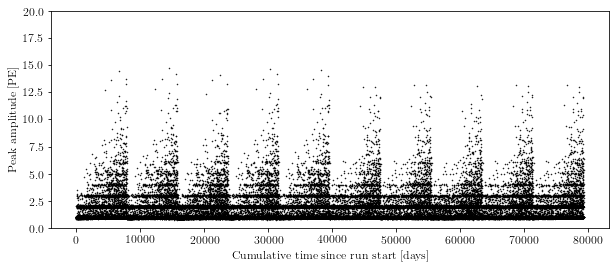

In [27]:
## now calibrate the rate plot in PE

time_vec = (all_data[:,0]-np.min(all_data[:,0]))/(3600*24)
amp_data_PE = []
ov_data = []

amp_data_dict = {}

print(didx)
    
for d in didx:
    
    if("ap_amp" in d): continue
        
    curr_data = data_dict[d]
    gain_data = gain_dict[d][0]
    OV_list = gain_dict[d][1]
   
    dd = int(d[0])
    rr = d[1:]
    vbd_list = vbd_dict[rr]
    curr_vbd = vbd_list[dd-1,:]

    curr_amp_data_PE = []
    for ov in OV_list:
        gpts = ov_dict[d[0]] == ov
        curr_gain = gain_data[OV_list == ov, 0][0]
        curr_amp_data = curr_data[gpts]/curr_gain
        
        amp_data_PE.extend(curr_amp_data)
        curr_amp_data_PE.extend(curr_amp_data)
        ov_data.extend(curr_data[gpts] - curr_vbd[0])
    amp_data_dict[d] = curr_amp_data_PE
        
amp_data_PE = np.array(amp_data_PE)
ov_data = np.array(ov_data)
print(np.shape(amp_data_PE))
    
fig=plt.figure()
gpts = amp_data_PE > 0.8
plt.plot( amp_data_PE[gpts], 'k.', ms=1)
plt.xlabel("Cumulative time since run start [days]")
plt.ylabel("Peak amplitude [PE]")
plt.ylim([0,20])
#plt.xlim([9.5, 10.5])
fig.set_size_inches(10,4)
plt.savefig("amp_vs_time_cal.pdf")

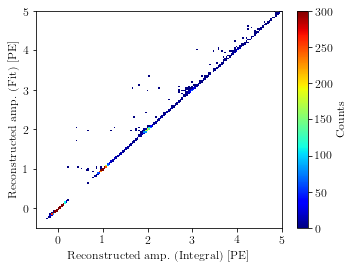

In [28]:
fig=plt.figure()
hh, xedges, yedges = np.histogram2d( amp_data_dict['1_integ'],amp_data_dict['1_fit'], bins=(400,400) )
hh[hh==0] = np.nan
plt.pcolormesh( xedges, yedges, hh.T, cmap='jet', rasterized=True, vmin=0, vmax=300)
plt.xlabel("Reconstructed amp. (Integral) [PE]")
plt.ylabel("Reconstructed amp. (Fit) [PE]")
plt.colorbar(label="Counts")
#plt.plot(amp_data_dict['1_integ'],amp_data_dict['1_fit'],'k.', ms=1)
fig.set_size_inches(5.5,4)
plt.savefig("recon_comp.pdf")
plt.xlim(-0.5,5)
plt.ylim(-0.5,5)
plt.savefig("recon_comp_zoom.pdf")
plt.show()

In [29]:
def get_ca_rate(data, r=20, lt=1, color='k', lab=''):
    
    data = data[data>0.5]
    
    hh, be = np.histogram(data, bins=np.arange(0,r,0.05))
    bc = be[:-1] + np.diff(be)/2

    if( len(lab)==0 ):
        plt.plot(bc, hh/lt, color=color)
        p=None
    else:
        p=plt.plot(bc, hh/lt, color=color, label=lab)
        
    plt.gca().set_yscale('log')
    #yy = plt.ylim((1e-3,2))
    plt.grid(True)
    #plt.xlim(0,6.5)
    
    # use standard error on mean of Poisson
    return np.mean(data)-1, np.std(data), np.sqrt(np.mean(data))/np.sqrt(len(data)), p

In [47]:
def plot_other_data():
    flist = ["nCP_VUVHD3_110_RMS.txt", "nCP_VUVHD3_110_2_RMS.txt", "nCP_VUVHD3_110_3_RMS.txt", "BNL_HD3_1.txt", "BNL_HD3_2.txt", "BNL_HD3_3.txt", "nCP_VUVHD3_iHEP_50C.txt", ]
    nlist = ["TRIUMF \#1", "TRIUMF \#2", "TRIUMF \#3", "BNL \#1", "BNL \#2", "BNL \#3", "IHEP \#1 (-50 C)"]
    fmtlist = ['bs','bo','b^', 'rs', 'ro', 'r^', 'gs']
    
    for f, n, fm in zip(flist, nlist, fmtlist):
        if("BNL" in n):
            dat = np.loadtxt("../data/"+f, delimiter=',')
        else:
            dat = np.loadtxt("../data/"+f)    
        if("IHEP" in n):
            plt.errorbar(dat[:,0], dat[:,2], xerr=dat[:,1], yerr=dat[:,3], fmt=fm, label=n)
        elif("BNL" in n):
            plt.errorbar(dat[:,0], dat[:,1], xerr=0, yerr=0, fmt=fm, label=n)
        else:
            plt.errorbar(dat[:,0], dat[:,3], xerr=dat[:,1], fmt=fm, label=n)
        
        

In [31]:
def plot_other_rms_data():
    flist = ["nCP_VUVHD3_110_RMS.txt", "nCP_VUVHD3_110_2_RMS.txt", "nCP_VUVHD3_110_3_RMS.txt", "BNL_HD3_1.txt", "BNL_HD3_2.txt", "nCP_VUVHD3_iHEP_50C.txt", ]
    nlist = ["TRIUMF \#1", "TRIUMF \#2", "TRIUMF \#3", "BNL \#1", "BNL \#2", "BNL \#3", "IHEP \#1 (-50 C)"]
    fmtlist = ['bs','bo','b^', 'rs', 'ro', 'gs']
    
    for f, n, fm in zip(flist, nlist, fmtlist):
        if("BNL" in n):
            continue
            #dat = np.loadtxt("../data/"+f, delimiter=',')
        else:
            dat = np.loadtxt("../data/"+f)    
        if("IHEP" in n):
            plt.errorbar(dat[:,0], dat[:,4], xerr=dat[:,1], yerr=dat[:,3], fmt=fm, label=n)
        elif("BNL" in n):
            plt.errorbar(dat[:,0], dat[:,1], xerr=0, yerr=0, fmt=fm, label=n)
        else:
            plt.errorbar(dat[:,0], dat[:,4], xerr=dat[:,1], fmt=fm, label=n)

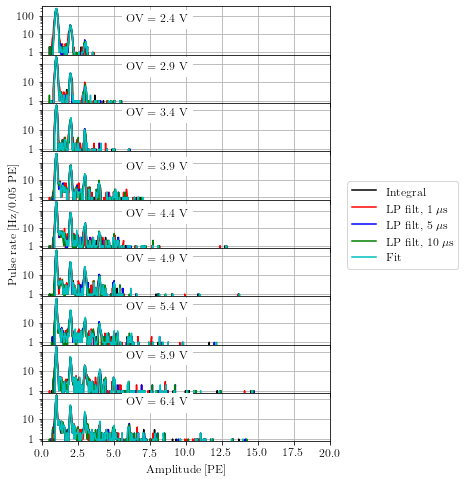

In [32]:
## spectral comparison plot vs recon method

recon_list = ['_integ', "_f5",  "_f10", "_f15", "_fit"]

col_list = ['k','r','b','g','c']
labels = [r"Integral", r"LP filt, 1 $\mu$s", r"LP filt, 5 $\mu$s", r"LP filt, 10 $\mu$s", r"Fit"]

plist = []

dd = 1
fig = plt.figure()
for cidx, r in enumerate(recon_list):
    
    d = str(dd) + r
    
    curr_data = data_dict[d]
    gain_data = gain_dict[d][0]
    OV_list = gain_dict[d][1]
    
    rr = d[1:]
    vbd_list = vbd_dict[rr]
    curr_vbd = vbd_list[dd-1,:]

    for i, ov in enumerate(OV_list):
        gpts = ov_dict[d[0]] == ov

        file_lt = 1
        #print(ov, file_lt)

        plt.subplot(len(OV_list),1,i+1)
        curr_gain = gain_data[OV_list == ov, 0][0]
        curr_amp_data = curr_data[gpts]/curr_gain
        
        Vbd = vbd_list[dd-1,0]
        
        if(i==0):
            ca, ca_rms, ca_err, p = get_ca_rate(curr_amp_data, lt=file_lt, color=col_list[cidx], lab=labels[cidx])
        else:
            ca, ca_rms, ca_err, p = get_ca_rate(curr_amp_data, lt=file_lt, color=col_list[cidx])

        if(not p == None):
            plist.append(p[0])
            
        if( i == 0):
            plt.gca().set_yticks([1,10,100])
            plt.gca().set_yticklabels([1,10,100])
        elif( True and i > 0):
            plt.gca().set_yticks([1,10,100])
            plt.gca().set_yticklabels([1,10,''])
        if(i == len(OV_list)-1):
            plt.xlabel("Amplitude [PE]")
        else:
            plt.gca().set_xticklabels([])
        if(i==4):
            plt.ylabel("Pulse rate [Hz/0.05 PE]")

        plt.text(8, 70, "OV = %.1f V"%(ov-Vbd), va='center', ha='center', color='k', weight='bold', backgroundcolor='white')
        plt.xlim([0,20])

plt.legend(plist, labels, bbox_to_anchor=(1.04,5.5), loc="upper left")
        
fig.subplots_adjust(hspace=0, left=0.1, right=0.6)
fig.set_size_inches(8,8)
plt.savefig("scint_spec_recon_comp.pdf")
    
    

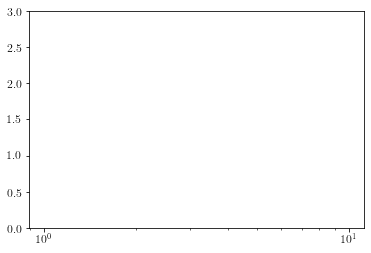

In [33]:
## 2d plot of amplitude versus time after

fig=plt.figure()
for d in didx:

    if('ap_amp' not in d): continue
        
    d2 = d[0] + "_fit"
    
    curr_data = data_dict[d]
    gain_data = gain_dict[d2][0]
    OV_list = gain_dict[d2][1]
    
    dd = int(d[0])
    rr = d2[1:]
    vbd_list = vbd_dict[rr]
    curr_vbd = vbd_list[dd-1,:]

    for i, ov in enumerate(OV_list):
        gpts = ov_dict[d[0]] == ov

        file_lt = 1
        #print(ov, file_lt)

        #plt.subplot(len(OV_list),1,i+1)
        curr_gain = gain_data[OV_list == ov, 0][0]
        curr_amp_data = curr_data[gpts, 6]/curr_gain
        curr_time_data = curr_data[gpts, 3]
        
        plt.plot(curr_time_data, curr_amp_data, 'k.', ms=1)
        #plt.xlim(0,1)
        
plt.gca().set_xscale('log')
plt.ylim([0,3])
plt.show()

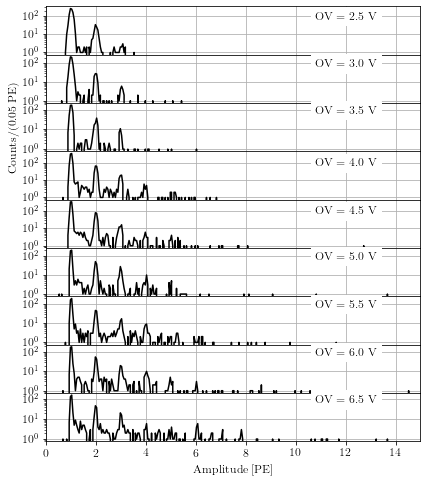

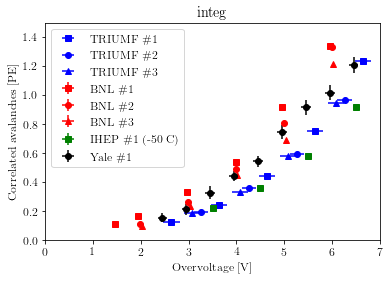

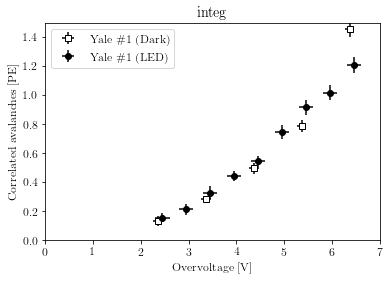

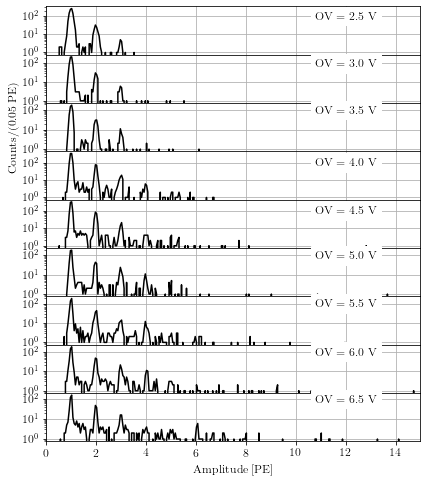

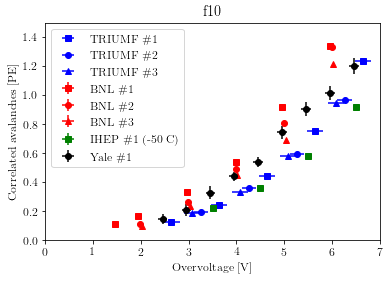

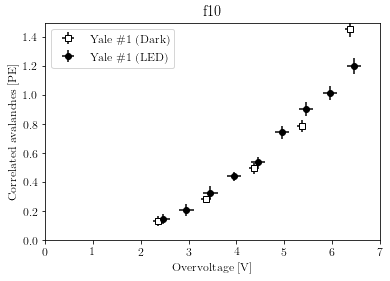

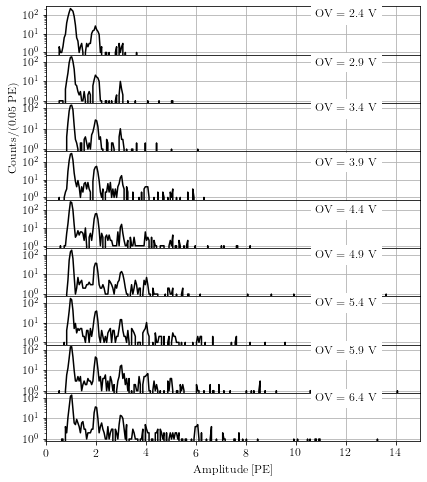

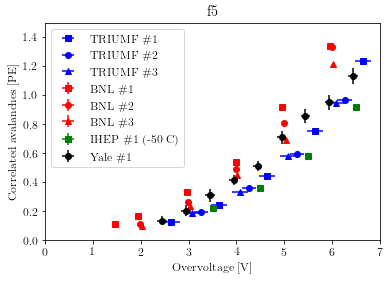

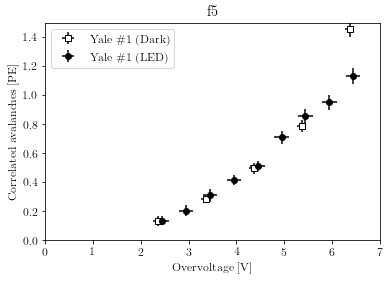

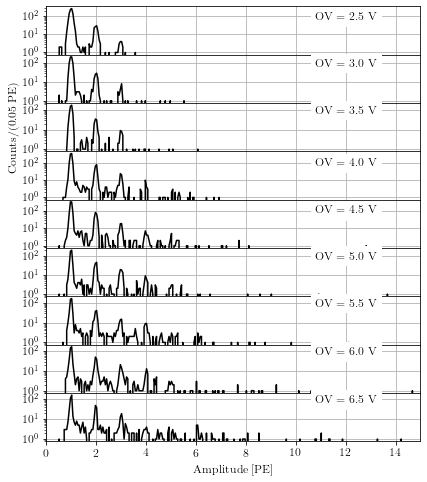

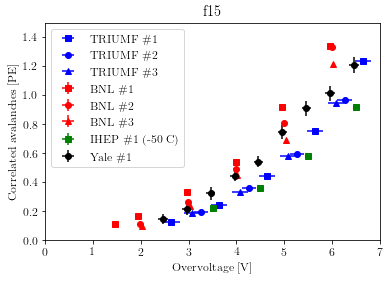

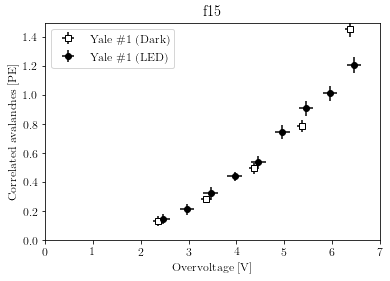

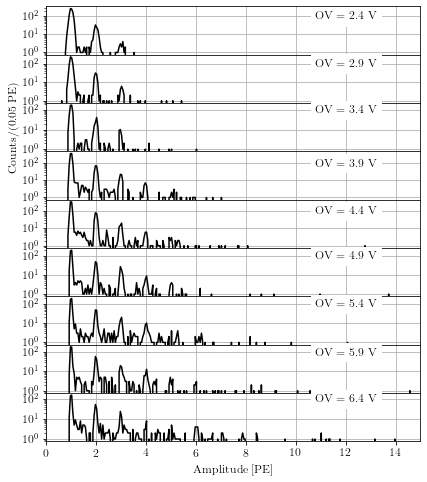

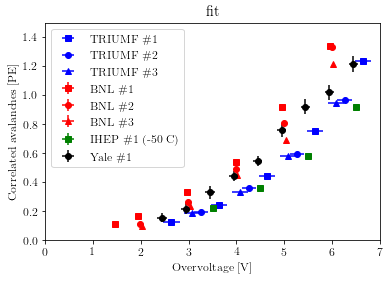

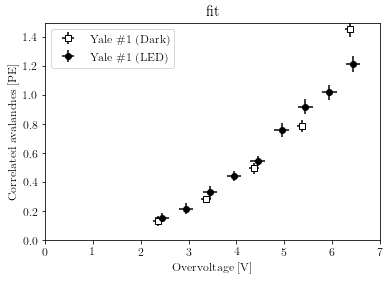

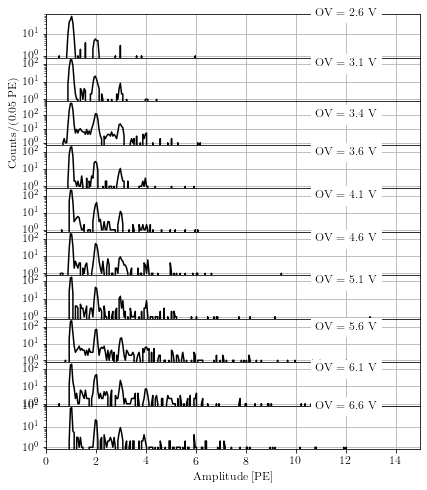

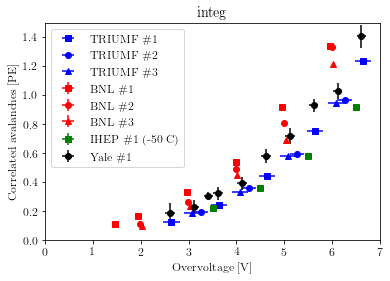

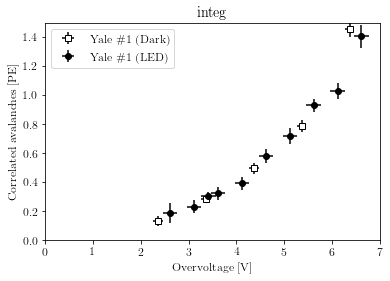

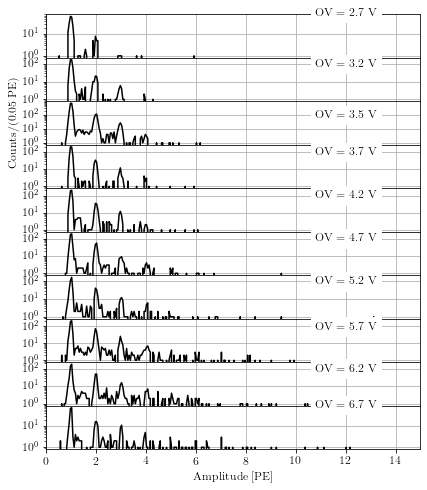

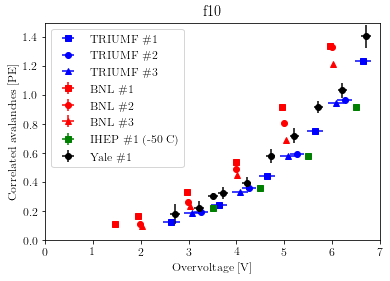

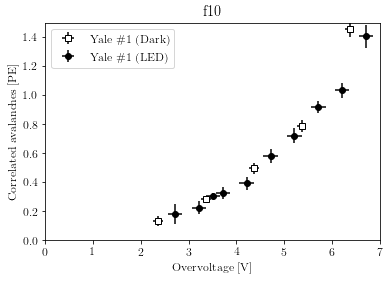

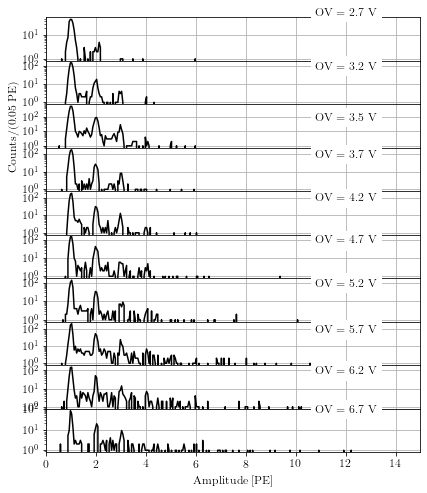

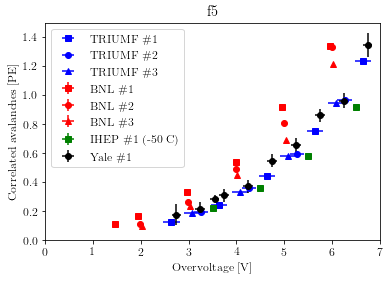

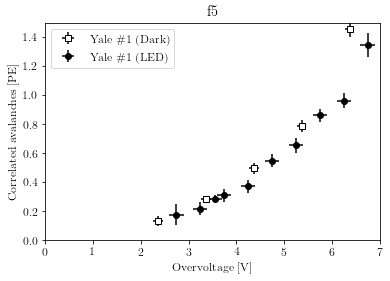

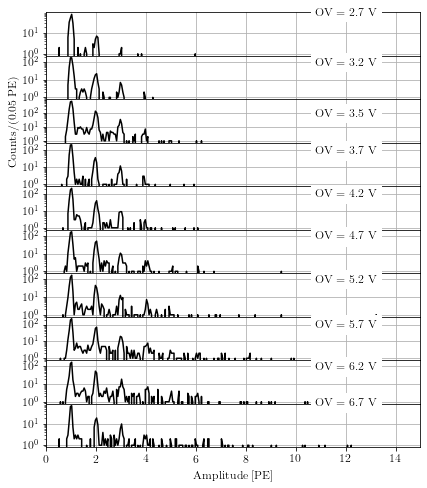

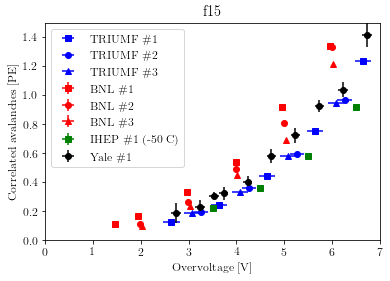

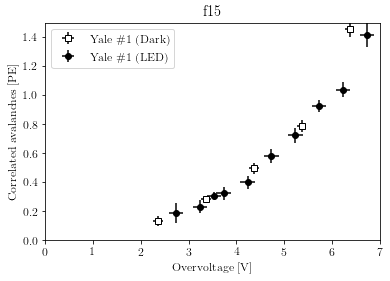

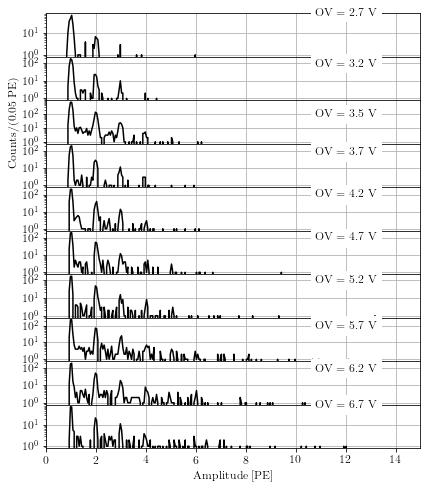

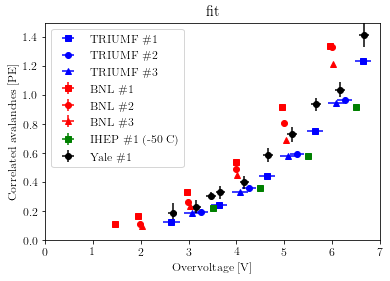

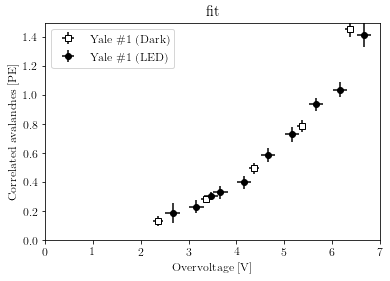

In [48]:
## make a plot of the correlated avalanches at each OV

col=['r', 'k']

for d in didx:

    fig=plt.figure()
    
    curr_data = data_dict[d]
    gain_data = gain_dict[d][0]
    OV_list = gain_dict[d][1]
    
    dd = int(d[0])
    rr = d[1:]
    vbd_list = vbd_dict[rr]
    curr_vbd = vbd_list[dd-1,:]
    
    #print(OV_list)
    ca_vs_ov = np.zeros((len(OV_list),3))

    for i, ov in enumerate(OV_list):
        gpts = ov_dict[d[0]] == ov

        file_lt = 1
        #print(ov, file_lt)

        plt.subplot(len(OV_list),1,i+1)
        curr_gain = gain_data[OV_list == ov, 0][0]
        curr_amp_data = curr_data[gpts]/curr_gain
        
        Vbd = vbd_list[dd-1,0]
        
        ca, ca_rms, ca_err, p = get_ca_rate(curr_amp_data, lt=file_lt, color='k')
        
        if( False and i > 0):
            plt.gca().set_yticks([1e-3,1e-2,1e-1,])
        if(i == len(OV_list)-1):
            plt.xlabel("Amplitude [PE]")
        else:
            plt.gca().set_xticklabels([])
        if(i==2):
            plt.ylabel("Counts/(0.05 PE)")

        plt.text(12, 1e2, "OV = %.1f V"%(ov-Vbd), va='center', ha='center', color='k', weight='bold', backgroundcolor='white')

        ca_vs_ov[i,0] = ca
        ca_vs_ov[i,1] = ca_rms
        ca_vs_ov[i,2] = ca_err
    
        plt.xlim([0,15])
        
        np.savez("ca_meas%s.npz"%d, x=OV_list-Vbd, xerr=0.1, y=ca_vs_ov[:,0], yerr=ca_vs_ov[:,2])
        np.savez("ca_std%s.npz"%d, x=OV_list-Vbd, xerr=0.1, y=ca_vs_ov[:,1], yerr=ca_vs_ov[:,2])
        
    fig.subplots_adjust(hspace=0, left=0.1)
    
    fig.set_size_inches(6.5,8)
    plt.savefig("scint_spec%s.pdf"%d)

    ca_fig = plt.figure()
    plot_other_data()
    plt.errorbar(OV_list-Vbd, ca_vs_ov[:,0], xerr=0.1, yerr=ca_vs_ov[:,2], fmt='ko', label="Yale \#1")

    plt.xlim([0,7])
    plt.ylim([0,1.5])
    plt.xlabel("Overvoltage [V]")
    plt.ylabel("Correlated avalanches [PE]")
    plt.title(d[2:])
    plt.legend()


    plt.figure()
    dd = np.load("ca_dark_data_20211203.npz")
    plt.errorbar(dd['x'], dd['y'], xerr=dd['xerr'], yerr=dd['yerr'], fmt='ks', mfc='white', label="Yale \#1 (Dark)")

    plt.errorbar(OV_list-Vbd, ca_vs_ov[:,0], xerr=0.15, yerr=ca_vs_ov[:,2], fmt='ko', label="Yale \#1 (LED)")

    plt.xlim([0,7])
    plt.ylim([0,1.5])
    plt.xlabel("Overvoltage [V]")
    plt.ylabel("Correlated avalanches [PE]")
    plt.title(d[2:])
    plt.legend()

    plt.show()


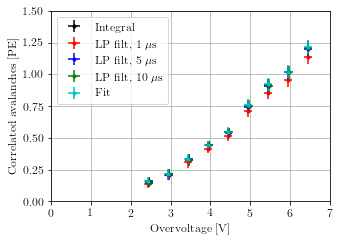

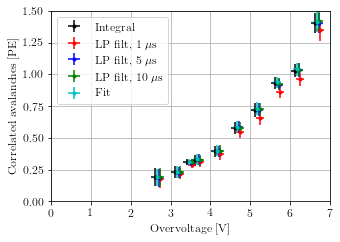

In [35]:
## load data and make the final results plots

recon_list = ['_integ', "_f5",  "_f10", "_f15", "_fit"]

col_list = ['k','r','b','g','c']

fig1 = plt.figure()
fig2 = plt.figure()
for dd in [1,2]:
    for i,r in enumerate(recon_list):
        
        d = str(dd) + r
        
        cdat = np.load("ca_meas%s.npz"%d)
        x = cdat['x']
        xerr = cdat['xerr']
        y = cdat['y']
        yerr = cdat['yerr']

        if(d[0] == '1'):
            plt.figure(fig1.number)
            plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt=col_list[i]+'.', label=labels[i])
        else:
            plt.figure(fig2.number)
            plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt=col_list[i]+'.', label=labels[i])

            
for i,f in enumerate([fig1, fig2]):
    plt.figure(f.number)
    plt.xlim([0,7])
    plt.ylim([0,1.5])
    plt.xlabel("Overvoltage [V]")
    plt.ylabel("Correlated avalanches [PE]")
    plt.legend(loc='upper left')
    plt.grid(True)
    f.set_size_inches(5,3.5)
    plt.savefig("ca_vs_recon_%d.pdf"%i)
plt.show()


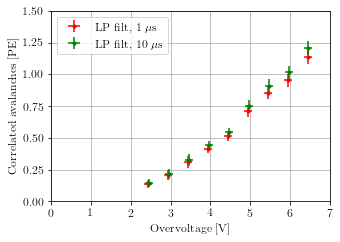

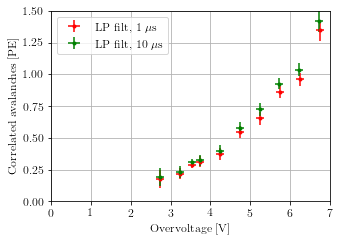

In [36]:
## load data and make the final results plots

recon_list = ['_integ', "_f5",  "_f10", "_f15", "_fit"]

col_list = ['k','r','b','g','c']

fig1 = plt.figure()
fig2 = plt.figure()
for dd in [1,2]:
    for i,r in enumerate(recon_list):
        
        if(not (r=='_f5' or r=='_f15')): continue
        
        d = str(dd) + r
        
        cdat = np.load("ca_meas%s.npz"%d)
        x = cdat['x']
        xerr = cdat['xerr']
        y = cdat['y']
        yerr = cdat['yerr']

        if(d[0] == '1'):
            plt.figure(fig1.number)
            plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt=col_list[i]+'.', label=labels[i])
        else:
            plt.figure(fig2.number)
            plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt=col_list[i]+'.', label=labels[i])

            
for i,f in enumerate([fig1, fig2]):
    plt.figure(f.number)
    plt.xlim([0,7])
    plt.ylim([0,1.5])
    plt.xlabel("Overvoltage [V]")
    plt.ylabel("Correlated avalanches [PE]")
    plt.legend(loc='upper left')
    plt.grid(True)
    f.set_size_inches(5,3.5)
    plt.savefig("ca_vs_integration_time_%d.pdf"%i)
plt.show()

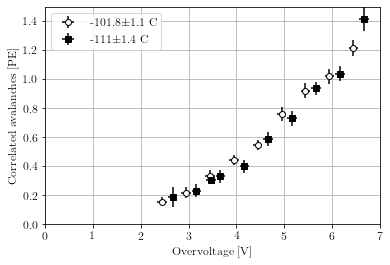

In [37]:
## now vs temperature (use fit)

plt.figure()

cdat = np.load("ca_meas1_fit.npz")
x = cdat['x']
xerr = cdat['xerr']
y = cdat['y']
yerr = cdat['yerr']

plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt='ko', ms=6, mfc='white', label='-101.8$\pm$1.1 C')

cdat = np.load("ca_meas2_fit.npz")
x = cdat['x']
xerr = cdat['xerr']
y = cdat['y']
yerr = cdat['yerr']


plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt='ks', ms=6, mfc='k', label='-111$\pm$1.4 C')

plt.xlim([0,7])
plt.ylim([0,1.5])
plt.xlabel("Overvoltage [V]")
plt.ylabel("Correlated avalanches [PE]")
plt.legend(loc='upper left')
plt.grid(True)
f.set_size_inches(5,3.5)
plt.savefig("ca_vs_temp.pdf")

plt.show()

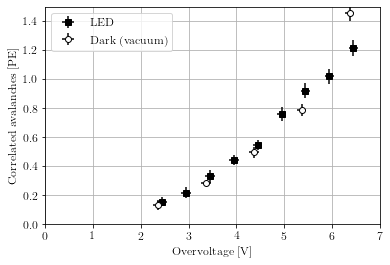

In [38]:
## now dark vs LED data

plt.figure()

cdat = np.load("ca_meas1_fit.npz")
x = cdat['x']
xerr = cdat['xerr']
y = cdat['y']
yerr = cdat['yerr']

plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt='ks', ms=6, mfc='k', label='LED')

cdat = np.load("ca_dark_data_20211203.npz")
#cdat = np.load("ca_meas2_fit.npz")
x = cdat['x']
xerr = cdat['xerr']
y = cdat['y']
yerr = cdat['yerr']


plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt='ko', ms=6, mfc='white', label='Dark (vacuum)')

plt.xlim([0,7])
plt.ylim([0,1.5])
plt.xlabel("Overvoltage [V]")
plt.ylabel("Correlated avalanches [PE]")
plt.legend(loc='upper left')
plt.grid(True)
f.set_size_inches(5,3.5)
plt.savefig("ca_vs_dark_led.pdf")

plt.show()

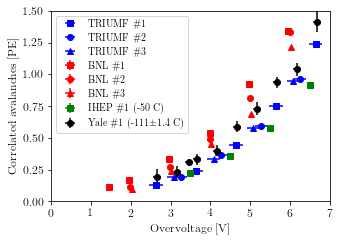

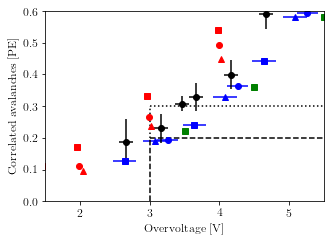

In [51]:
ca_fig = plt.figure()
plot_other_data()

cdat = np.load("ca_meas2_fit.npz")
x = cdat['x']
xerr = cdat['xerr']
y = cdat['y']
yerr = cdat['yerr']


plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt='ko', ms=6, mfc='k', label='Yale \#1 (-111$\pm$1.4 C)')


CA_array = np.vstack([x, xerr*np.ones_like(x), y, yerr])

plt.xlim([0,7])
plt.ylim([0,1.5])
plt.xlabel("Overvoltage [V]")
plt.ylabel("Correlated avalanches [PE]")
ca_fig.set_size_inches(5,3.5)
plt.legend(fontsize=10)
plt.savefig("CA_fit_results_all.pdf")

ca_fig2 = plt.figure()
plot_other_data()

cdat = np.load("ca_meas2_fit.npz")
x = cdat['x']
xerr = cdat['xerr']
y = cdat['y']
yerr = cdat['yerr']


plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt='ko', ms=6, mfc='k', label='Yale \#1 (-111$\pm$1.4 C)')

plt.plot((3,3),(0,0.2), 'k--', lw=1.5)
plt.plot((3,7),(0.2,0.2), 'k--', lw=1.5)
plt.plot((3,3),(0.2,0.3), 'k:', lw=1.5)
plt.plot((3,7),(0.3,0.3), 'k:', lw=1.5)



plt.xlim([1.5,5.5])
plt.ylim([0,0.6])
plt.xlabel("Overvoltage [V]")
plt.ylabel("Correlated avalanches [PE]")
ca_fig2.set_size_inches(5,3.5)
#plt.legend()
plt.savefig("CA_fit_results_all_zoom.pdf")


Corr avalanches (VUV HD3), Yale 12/10/2021:
OV (V)  OV error (V)  CA [PE] CA error [PE]  CA RMS [PE]  CA RMS error [PE]
[[2.665 0.1   0.187 0.071 0.554 0.071]
 [3.165 0.1   0.229 0.045 0.53  0.045]
 [3.465 0.1   0.307 0.024 0.632 0.024]
 [3.665 0.1   0.33  0.044 0.708 0.044]
 [4.165 0.1   0.4   0.045 0.784 0.045]
 [4.665 0.1   0.589 0.047 1.056 0.047]
 [5.165 0.1   0.73  0.053 1.268 0.053]
 [5.665 0.1   0.937 0.045 1.532 0.045]
 [6.165 0.1   1.039 0.052 1.7   0.052]
 [6.665 0.1   1.414 0.082 2.084 0.082]]


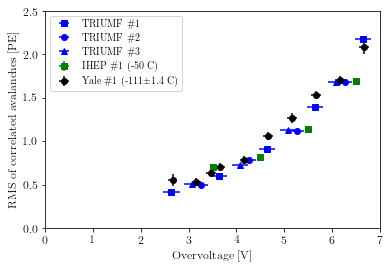

In [40]:
ca_rms_fig = plt.figure()
plot_other_rms_data()

cdat = np.load("ca_std2_fit.npz")
x = cdat['x']
xerr = cdat['xerr']
y = cdat['y']
yerr = cdat['yerr']

CA_array = np.vstack([CA_array, y, yerr])

np.set_printoptions(precision=3)
print("Corr avalanches (VUV HD3), Yale 12/10/2021:")
print("OV (V)  OV error (V)  CA [PE] CA error [PE]  CA RMS [PE]  CA RMS error [PE]")
print(CA_array.T)

plt.errorbar( x, y, xerr=xerr, yerr=yerr, fmt='ko', ms=6, mfc='k', label='Yale \#1 (-111$\pm$1.4 C)')

plt.xlim([0,7])
plt.ylim([0,2.5])
plt.xlabel("Overvoltage [V]")
plt.ylabel("RMS of correlated avalanches [PE]")
ca_fig.set_size_inches(5,3.5)
plt.legend(fontsize=10)
plt.savefig("CA_fit_results_rms_all.pdf")

plt.show()

In [41]:
## function to return temperature based on Vbd

def temp_from_vbd(v, verr):
    kappa = 28.2 # mV/K based on Ako's measurement https://nexowiki.llnl.gov/images/f/f2/20211117_SiPM_Fitting.pdf
    vbd_ako = 27.38
    t_ako = -107.5 # C
    
    tout = t_ako + (v-vbd_ako)/(kappa*1e-3)
    tout_err = verr/(kappa*1e-3)
    
    print("Temp at %.2f OV is: %.1f $\pm$ %.1f"%(v, tout, tout_err))
    


In [42]:
temp_from_vbd(27.54, 0.03)

Temp at 27.54 OV is: -101.8 $\pm$ 1.1


In [43]:
temp_from_vbd(27.28, 0.04)

Temp at 27.28 OV is: -111.0 $\pm$ 1.4


[[2.755e+01 3.048e-02 2.750e+01 2.413e-02]
 [2.739e+01 5.640e-02 2.728e+01 2.745e-02]]
[[2.756e+01 2.658e-02 2.757e+01 2.295e-02]
 [2.726e+01 3.254e-02 2.727e+01 4.774e-02]]
[[27.546  0.031 27.545  0.03 ]
 [27.286  0.048 27.241  0.042]]
[[27.539  0.028 27.545  0.03 ]
 [27.267  0.054 27.257  0.068]]
[[2.756e+01 2.702e-02 2.753e+01 2.170e-02]
 [2.734e+01 4.804e-02 2.732e+01 3.827e-02]]


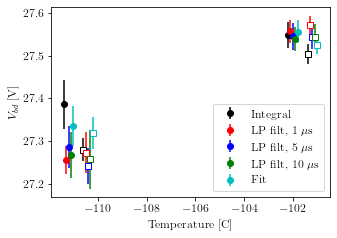

In [44]:
## make a plot of the Vbd versus method

fig=plt.figure()

col_list = ['k','r','b','g','c']
recon_list = ['_integ', "_f5",  "_f10", "_f15", "_fit"]
for ir, rr in enumerate(recon_list):
    vbd_list = vbd_dict[rr]
    print(vbd_list)
    
    plt.errorbar(-111 + 0.1*ir-0.4, vbd_list[1][0], yerr=vbd_list[1][1], fmt=col_list[ir]+'o', label=labels[ir])
    
    plt.errorbar(-111 + 0.1*ir + 0.4, vbd_list[1][2], yerr=vbd_list[1][3], fmt=col_list[ir]+'s', mfc ='white')
    
    plt.errorbar(-101.8 + 0.1*ir - 0.4, vbd_list[0][0], yerr=vbd_list[0][1], fmt=col_list[ir]+'o')
    
    plt.errorbar(-101.8 + 0.1*ir + 0.4, vbd_list[0][2], yerr=vbd_list[0][3], fmt=col_list[ir]+'s', mfc ='white')

plt.xlabel("Temperature [C]")
plt.ylabel("$V_{bd}$ [V]")
plt.legend(loc='lower right')
fig.set_size_inches(5, 3.5)
plt.savefig("vbd_cross_check.pdf")
plt.show()